In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install psycopg2-binary
    !pip install cmake
    !pip install eli5
    !pip install pdpbox
    !pip install shap

In [59]:
# # LightGBM GPU update
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd LightGBM
!mkdir build
%cd build
!cmake ../../LightGBM -DUSE_GPU=1
#!cmake ../../LightGBM
!make -j$(nproc)
!sudo apt-get -y install python-pip

%cd ../python-package
!python3 setup.py install --gpu

Cloning into 'LightGBM'...
remote: Enumerating objects: 26728, done.
remote: Counting objects: 100% (3990/3990), done.
remote: Compressing objects: 100% (299/299), done.
remote: Total 26728 (delta 3829), reused 3727 (delta 3687), pack-reused 22738
Receiving objects: 100% (26728/26728), 19.23 MiB | 15.72 MiB/s, done.
Resolving deltas: 100% (19841/19841), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
remot

In [ ]:
# !pip uninstall xgboost
# !pip install xgboost==0.9
# import xgboost as xgb
# xgb.__version__

In [1]:
import psycopg2
import pandas.io.sql as psql
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from scipy.stats import randint, uniform

from pdpbox.pdp import pdp_isolate, pdp_plot
import shap
import eli5
from eli5.sklearn import PermutationImportance


# 모델 관련
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# 평가지표
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


# 하이퍼파라미터 튜닝
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Error 생략
pd.options.mode.chained_assignment = None 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#한글 Font
import matplotlib as mpl
mpl.rc("font", family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)

# graph style
plt.style.use('fivethirtyeight')
sns.set(font_scale = 1.0)

# 그래프 선명하게
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# Load Dataset

In [2]:
db = psycopg2.connect(host='john.db.elephantsql.com', dbname='mptqsere',user='mptqsere',password='XmjhDueuKG8ReGkOm7nGXunlDwevVI3L',port=5432)
df = psql.read_sql('SELECT * FROM steamspy_dataset', db)

In [3]:
df = df[df['release_year'] <= 2022] # 2024년의 데이터에 포함되어 있어, 이상치로 생각해 제거
df = df.reset_index(drop=True)
df = df.rename(columns = {'FirstGenre':'Genre'})

In [4]:
df

,appid,name,developer,publisher,owners,average_playtime_from_2009,initial_price,current_price,discount_precent,ccu,...,Co-op,OpenWorld,Horror,Violent,Sexual,Num_Language,Korean,discount,price_group,steam_userscore_group
0,10,Counter-Strike,Valve,Valve,"10,000,000-100,000,000",216,9.99,1.99,80.0,12620,...,0,0,0,0,0,8,1,1,5.99 .. 11.99,Very Positive
1,20,Team Fortress Classic,Valve,Valve,"1,000,000-10,000,000",3,4.99,0.99,80.0,99,...,1,0,0,1,0,9,1,1,2.99 .. 5.99,Very Positive
2,30,Day of Defeat,Valve,Valve,"1,000,000-10,000,000",5,4.99,0.99,80.0,133,...,1,0,0,0,0,5,0,1,2.99 .. 5.99,Very Positive
3,40,Deathmatch Classic,Valve,Valve,"1,000,000-10,000,000",0,4.99,0.99,80.0,6,...,1,0,0,1,0,9,1,1,2.99 .. 5.99,Very Positive
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,"1,000,000-10,000,000",4,4.99,0.99,80.0,157,...,1,0,0,1,0,4,1,1,2.99 .. 5.99,Very Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36311,1483110,Alien AI,GridSky Software AS,GridSky Software AS,"0-100,000",0,9.99,4.99,50.0,0,...,0,0,1,0,0,1,0,1,5.99 .. 11.99,Mixed
36312,1483130,Puzlkind,"Michael Ferrier, Sarah Jane Lapp",IronZog LLC,"0-100,000",0,0.00,0.00,0.0,0,...,0,0,0,0,0,1,0,0,Free,Mixed
36313,1483140,The Trap,Technolomics,Technolomics,"0-100,000",0,1.99,1.99,0.0,0,...,0,0,1,0,0,1,0,0,0.899 .. 2.99,Mixed
36314,1483300,MazM: The Phantom of the Opera,Growing Seeds,"CFK Co., Ltd.","0-100,000",0,14.99,7.49,50.0,1,...,0,0,0,0,0,7,1,1,11.99 .. 199.99,Mixed


In [5]:
df.columns

Index(['appid', 'name', 'developer', 'publisher', 'owners',
       'average_playtime_from_2009', 'initial_price', 'current_price',
       'discount_precent', 'ccu', 'release_year', 'Genre', 'Indie',
       'Multiplayer', 'Co-op', 'OpenWorld', 'Horror', 'Violent', 'Sexual',
       'Num_Language', 'Korean', 'discount', 'price_group',
       'steam_userscore_group'],
      dtype='object')

# EDA

## Categorical Variable 수치화

In [6]:
df.Genre.value_counts()

Action        16544
Adventure      8228
Casual         6623
Simulation     1658
Strategy       1543
RPG            1135
Racing          353
Sports          232
Name: Genre, dtype: int64

In [7]:
df.loc[df[df['Genre'] == 'Action'].index, 'Genre'] = 0
df.loc[df[df['Genre'] == 'Adventure'].index, 'Genre'] = 1
df.loc[df[df['Genre'] == 'Casual'].index, 'Genre'] = 2
df.loc[df[df['Genre'] == 'Simulation'].index, 'Genre'] = 3
df.loc[df[df['Genre'] == 'Strategy'].index, 'Genre'] = 4
df.loc[df[df['Genre'] == 'RPG'].index, 'Genre'] = 5
df.loc[df[df['Genre'] == 'Racing'].index, 'Genre'] = 6
df.loc[df[df['Genre'] == 'Sports'].index, 'Genre'] = 7

In [8]:
df.owners.value_counts()

0-100,000                 30801
100,000-1,000,000          4639
1,000,000-10,000,000        822
10,000,000-100,000,000       54
Name: owners, dtype: int64

In [9]:
df.loc[df[df['owners'] == '0-100,000'].index, 'owners'] = 0
df.loc[df[df['owners'] == '100,000-1,000,000'].index, 'owners'] = 1
df.loc[df[df['owners'] == '1,000,000-10,000,000'].index, 'owners'] = 2
df.loc[df[df['owners'] == '10,000,000-100,000,000'].index, 'owners'] = 3

In [10]:
df.price_group.value_counts()

0.899 .. 2.99      8295
5.99 .. 11.99      7742
11.99 .. 199.99    7138
2.99 .. 5.99       6818
Free               6323
Name: price_group, dtype: int64

In [11]:
df.loc[df[df['price_group'] == 'Free'].index, 'price_group'] = 0
df.loc[df[df['price_group'] == '0.899 .. 2.99'].index, 'price_group'] = 1
df.loc[df[df['price_group'] == '2.99 .. 5.99'].index, 'price_group'] = 2
df.loc[df[df['price_group'] == '5.99 .. 11.99'].index, 'price_group'] = 3
df.loc[df[df['price_group'] == '11.99 .. 199.99'].index, 'price_group'] = 4

In [12]:
df.steam_userscore_group.value_counts()

Mixed              18066
Very Positive       9122
Mostly Positive     7075
Mostly Negative     1992
Very Negative         61
Name: steam_userscore_group, dtype: int64

In [13]:
df.loc[df[df['steam_userscore_group'] == 'Very Negative'].index, 'steam_userscore_group'] = 0
df.loc[df[df['steam_userscore_group'] == 'Mostly Negative'].index, 'steam_userscore_group'] = 1
df.loc[df[df['steam_userscore_group'] == 'Mixed'].index, 'steam_userscore_group'] = 2
df.loc[df[df['steam_userscore_group'] == 'Mostly Positive'].index, 'steam_userscore_group'] = 3
df.loc[df[df['steam_userscore_group'] == 'Very Positive'].index, 'steam_userscore_group'] = 4

In [14]:
df['price_group'] = df['price_group'].astype('category')
df['steam_userscore_group'] = df['steam_userscore_group'].astype('category')

## 리뷰평가와 다른 특성들의 관계

### Average Playtime

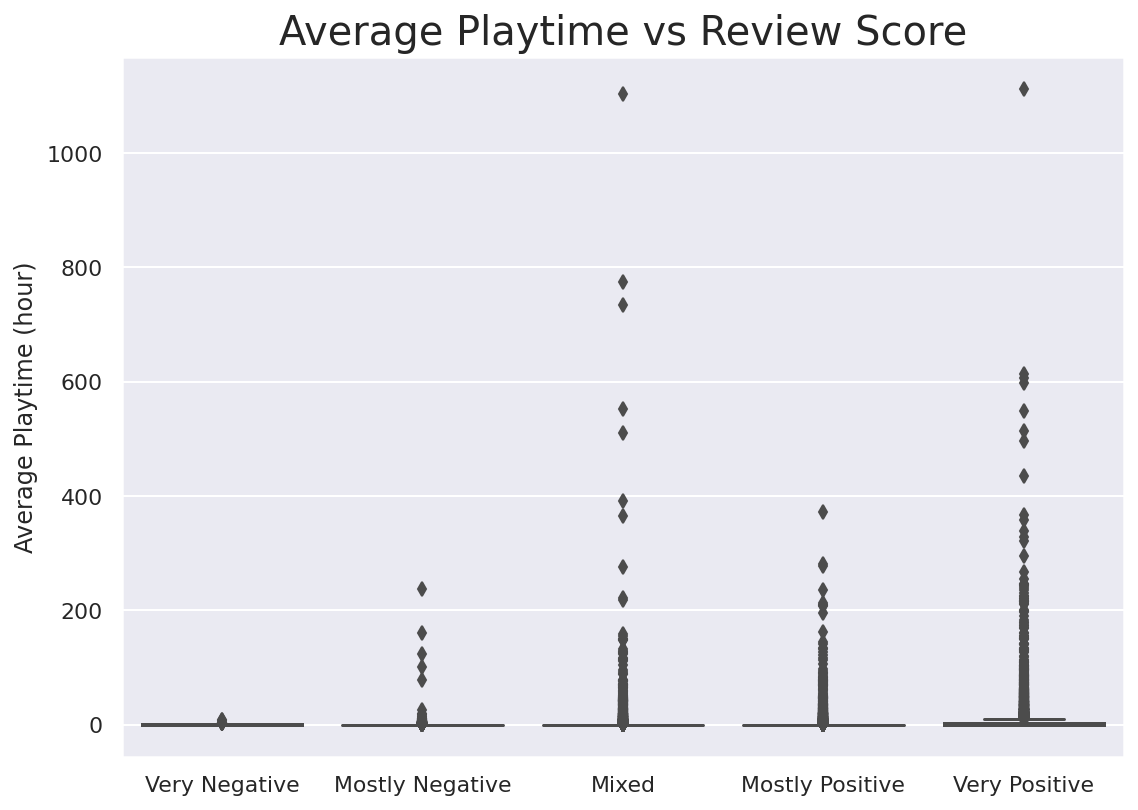

In [ ]:
plt.figure(figsize=(8,6))
fig = sns.boxplot(x='steam_userscore_group', y='average_playtime_from_2009', data=df)
plt.ylabel('Average Playtime (hour)')
plt.xlabel('')
plt.title('Average Playtime vs Review Score', fontsize=20)
fig.set_xticklabels(['Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
plt.show()

In [ ]:
df[(df['steam_userscore_group'] == 2)].sort_values(by = 'average_playtime_from_2009', ascending=False).head(5)

,appid,name,developer,publisher,owners,average_playtime_from_2009,initial_price,current_price,discount_precent,ccu,...,Co-op,OpenWorld,Horror,Violent,Sexual,Num_Language,Korean,discount,price_group,steam_userscore_group
4717,350300,Gang of Four,Days of Wonder,"Days of Wonder, Asmodee Digital",0,1103,0.00,0.00,0.0,1,...,0,0,0,0,0,2,0,0,0,2
8512,482730,Football Manager 2017,Sports Interactive,SEGA,2,775,0.00,0.00,0.0,1044,...,0,0,0,0,0,17,1,0,0,2
14838,699240,Keyboard Killers,Heaven Brotherhood,"Heaven Brotherhood, GrabTheGames",1,735,0.00,0.00,0.0,0,...,0,0,0,0,0,1,0,0,0,2
20197,872410,ROMANCE OF THE THREE KINGDOMS XIV,"KOEI TECMO GAMES CO., LTD.","KOEI TECMO GAMES CO., LTD.",1,553,59.99,35.99,40.0,3229,...,0,0,0,0,0,5,1,1,4,2
24870,1041320,Lords Mobile,IGG SINGAPORE PTE. LTD.,IGG SINGAPORE PTE. LTD.,1,510,0.00,0.00,0.0,3236,...,0,0,0,1,0,18,1,0,0,2


In [ ]:
df[(df['steam_userscore_group'] == 4)].sort_values(by = 'average_playtime_from_2009', ascending=False).head(5)

,appid,name,developer,publisher,owners,average_playtime_from_2009,initial_price,current_price,discount_precent,ccu,...,Co-op,OpenWorld,Horror,Violent,Sexual,Num_Language,Korean,discount,price_group,steam_userscore_group
27221,1125480,School Years,YEARS,电钮组,0,1113,11.99,2.39,80.0,6,...,0,0,1,0,1,3,0,1,3,4
22,570,Dota 2,Valve,Valve,3,613,0.00,0.00,0.0,620682,...,1,0,0,0,0,28,1,0,0,4
6871,420440,Atlantic Fleet,Killerfish Games,Killerfish Games,0,607,9.99,4.99,50.0,52,...,0,0,0,0,0,1,0,1,3,4
22828,967250,DOKA 2 KISHKI EDITION,Agafonoff,Agafonoff,1,598,0.99,0.49,51.0,46,...,0,0,0,1,1,2,0,1,1,4
13359,655500,MX Bikes,PiBoSo,PiBoSo,1,549,34.99,34.99,0.0,1329,...,0,0,0,0,0,1,0,0,4,4


### Owner

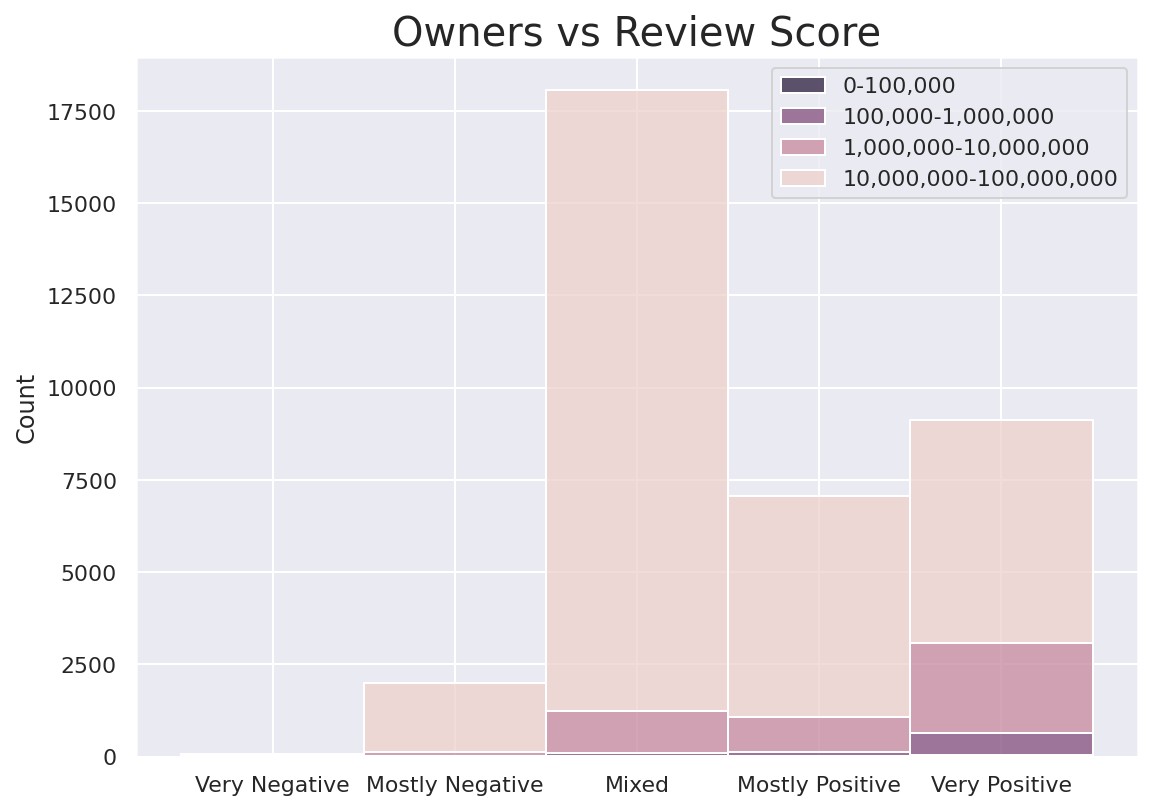

In [ ]:
plt.figure(figsize=(8,6))
fig = sns.histplot(x='steam_userscore_group', data=df, hue = 'owners', multiple='stack')
plt.xlabel('')
fig.set_xticklabels([0, 'Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
fig.legend(labels=['0-100,000', '100,000-1,000,000', '1,000,000-10,000,000', '10,000,000-100,000,000'])
plt.title('Owners vs Review Score', fontsize=20)
plt.show()

### 게임 가격대

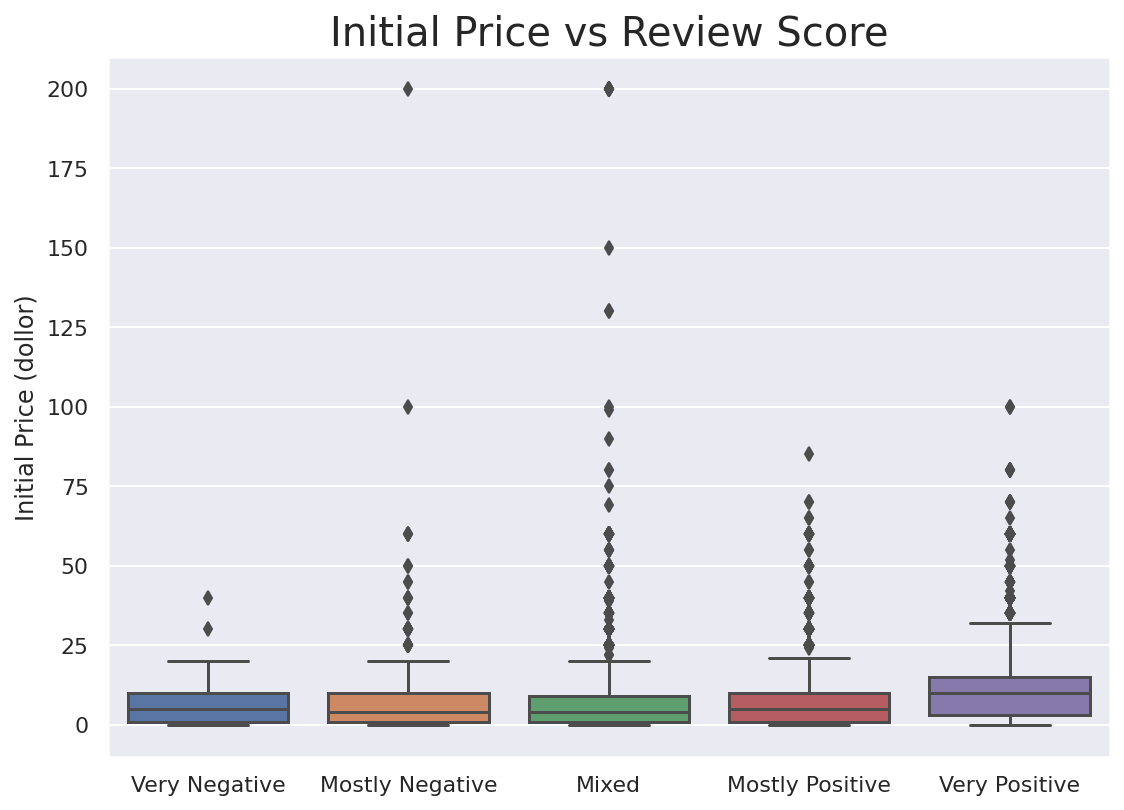

In [ ]:
# 출시가격
plt.figure(figsize=(8,6))
fig = sns.boxplot(x='steam_userscore_group', y='initial_price', data=df)
plt.ylabel('Initial Price (dollor)')
plt.xlabel('')
fig.set_xticklabels(['Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
plt.title('Initial Price vs Review Score', fontsize=20)
plt.show()

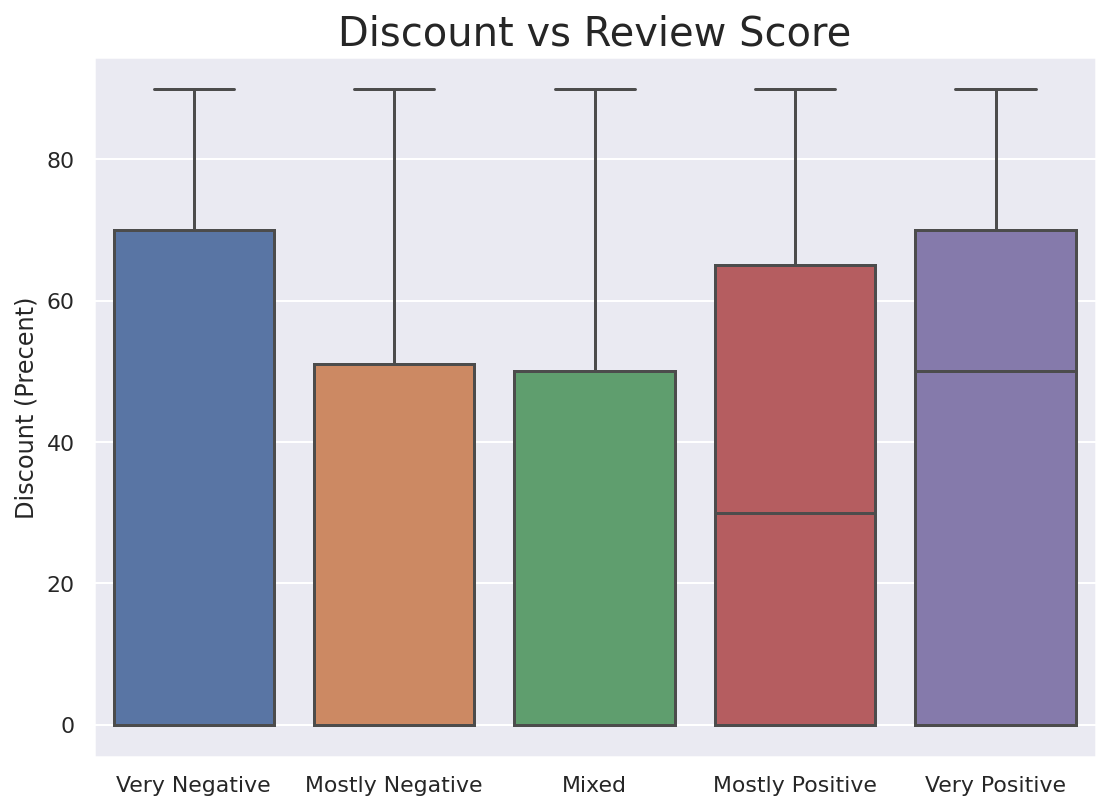

In [ ]:
# 할인율
plt.figure(figsize=(8,6))
fig = sns.boxplot(x='steam_userscore_group', y='discount_precent', data=df)
plt.ylabel('Discount (Precent)')
plt.xlabel('')
fig.set_xticklabels(['Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
plt.title('Discount vs Review Score', fontsize=20)
plt.show()

### 출시 연도

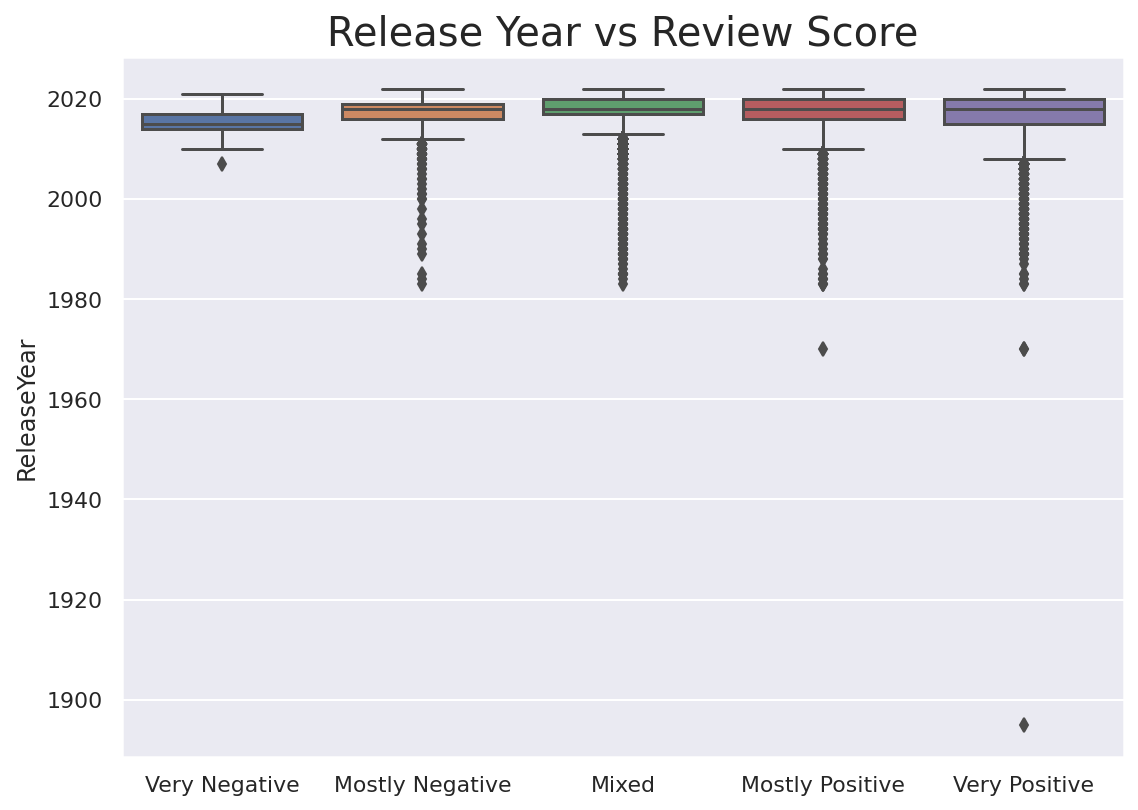

In [ ]:
plt.figure(figsize=(8,6))
fig = sns.boxplot(x='steam_userscore_group', y='release_year', data=df)
plt.ylabel('ReleaseYear')
plt.xlabel('')
fig.set_xticklabels(['Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
plt.title('Release Year vs Review Score', fontsize=20)
plt.show()

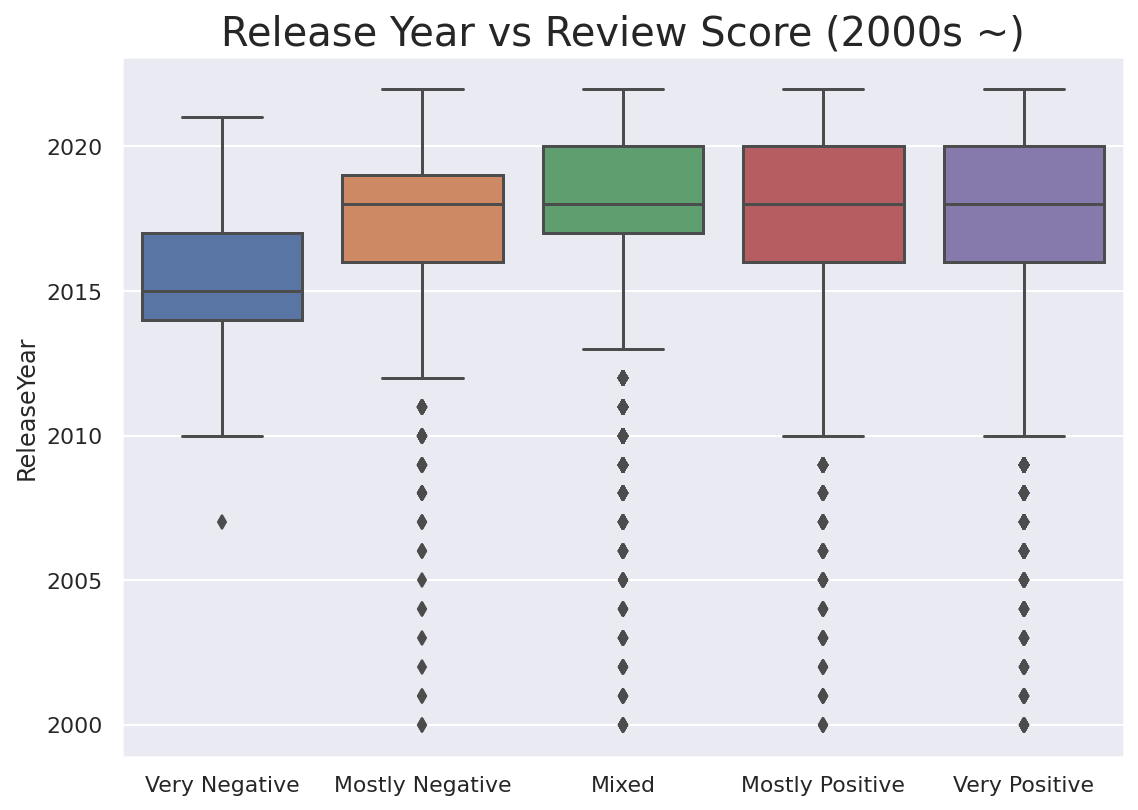

In [ ]:
plt.figure(figsize=(8,6))
fig = sns.boxplot(x='steam_userscore_group', y='release_year', data=df[df['release_year'] >= 2000])
plt.ylabel('ReleaseYear')
plt.xlabel('')
fig.set_xticklabels(['Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
plt.title('Release Year vs Review Score (2000s ~)', fontsize=20)
plt.show()

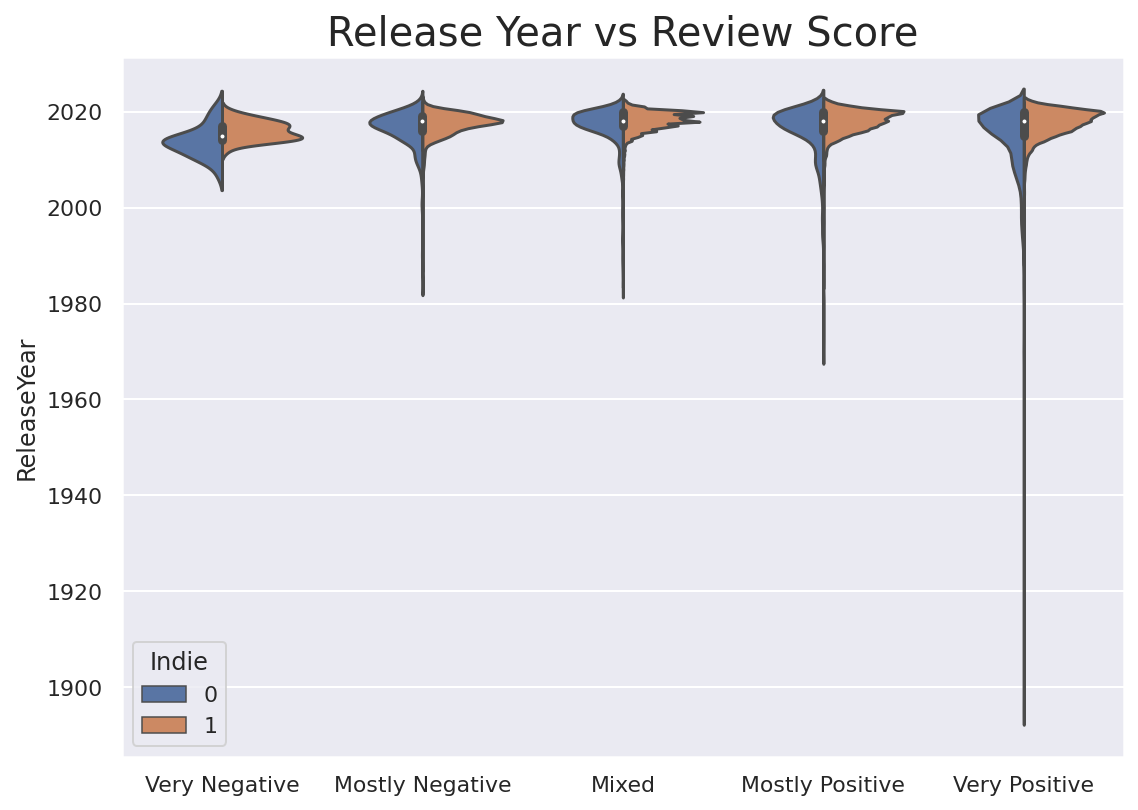

In [ ]:
plt.figure(figsize=(8,6))
fig = sns.violinplot(x='steam_userscore_group', y='release_year', data=df, hue='Indie', split=True)
plt.ylabel('ReleaseYear')
plt.xlabel('')
fig.set_xticklabels(['Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
plt.title('Release Year vs Review Score', fontsize=20)
plt.show()

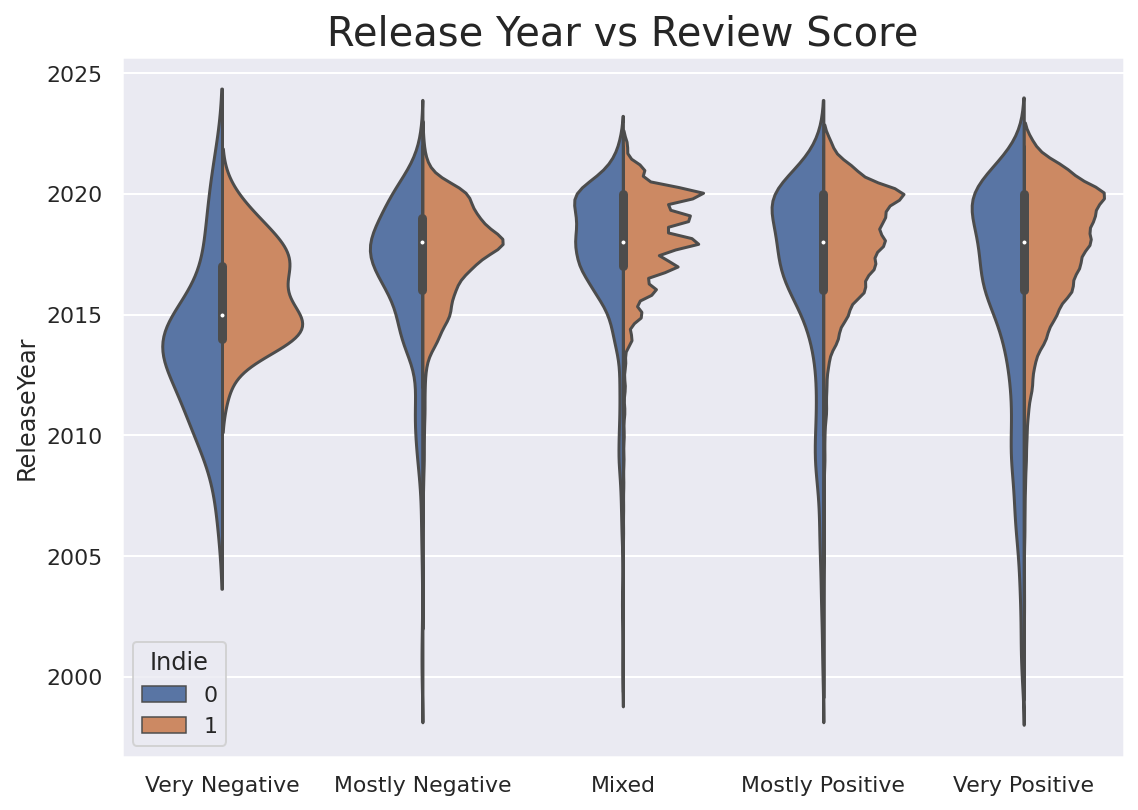

In [ ]:
plt.figure(figsize=(8,6))
fig = sns.violinplot(x='steam_userscore_group', y='release_year', data=df[df['release_year'] >= 2000], hue='Indie', split=True)
plt.ylabel('ReleaseYear')
plt.xlabel('')
fig.set_xticklabels(['Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
plt.title('Release Year vs Review Score', fontsize=20)
plt.show()

### 지원 언어수

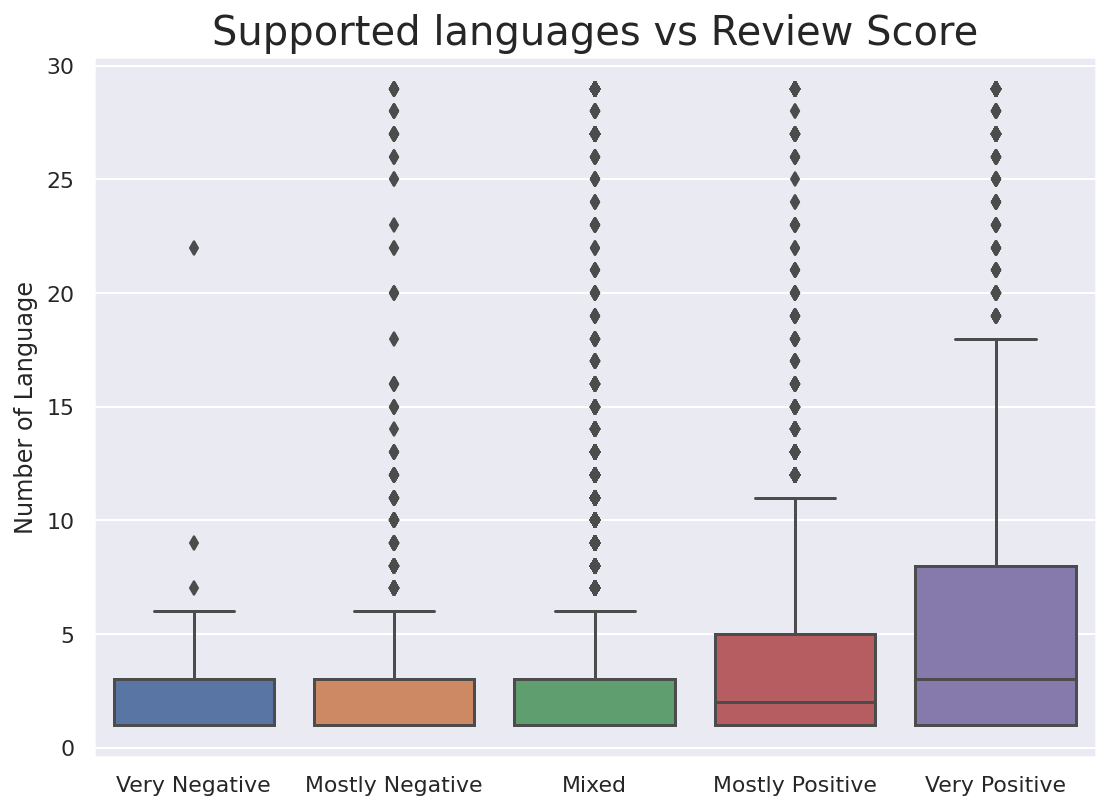

In [ ]:
plt.figure(figsize=(8,6))
fig = sns.boxplot(x='steam_userscore_group', y='Num_Language', data=df)
plt.ylabel('Number of Language')
plt.xlabel('')
fig.set_xticklabels(['Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
plt.title('Supported languages vs Review Score', fontsize=20)
plt.show()

In [ ]:
df.columns

Index(['appid', 'name', 'developer', 'publisher', 'owners',
       'average_playtime_from_2009', 'initial_price', 'current_price',
       'discount_precent', 'ccu', 'release_year', 'FirstGenre', 'Indie',
       'Multiplayer', 'Co-op', 'OpenWorld', 'Horror', 'Violent', 'Sexual',
       'Num_Language', 'Korean', 'discount', 'price_group',
       'steam_userscore_group'],
      dtype='object')

### 게임 장르

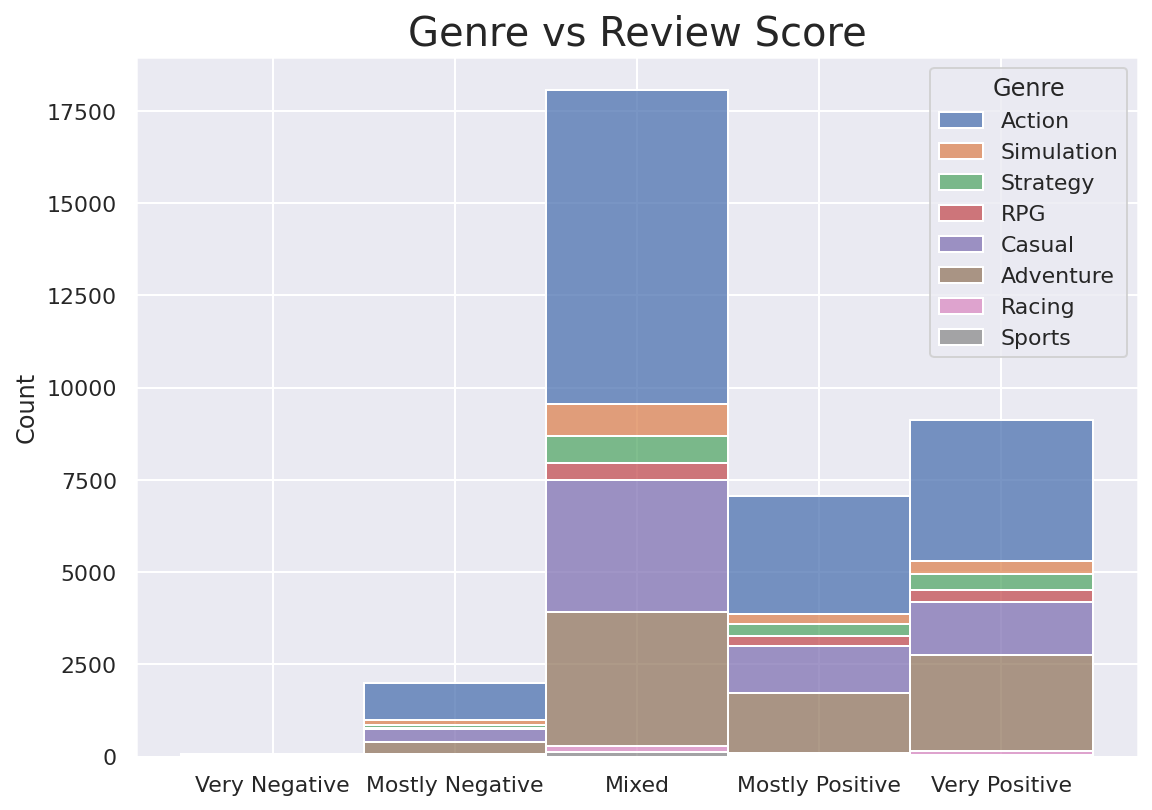

In [ ]:
plt.figure(figsize=(8,6))
fig = sns.histplot(x='steam_userscore_group', data=df, hue = 'Genre', multiple='stack')
plt.xlabel('')
fig.set_xticklabels([0, 'Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
plt.title('Genre vs Review Score', fontsize=20)
plt.show()

### Binary Variable

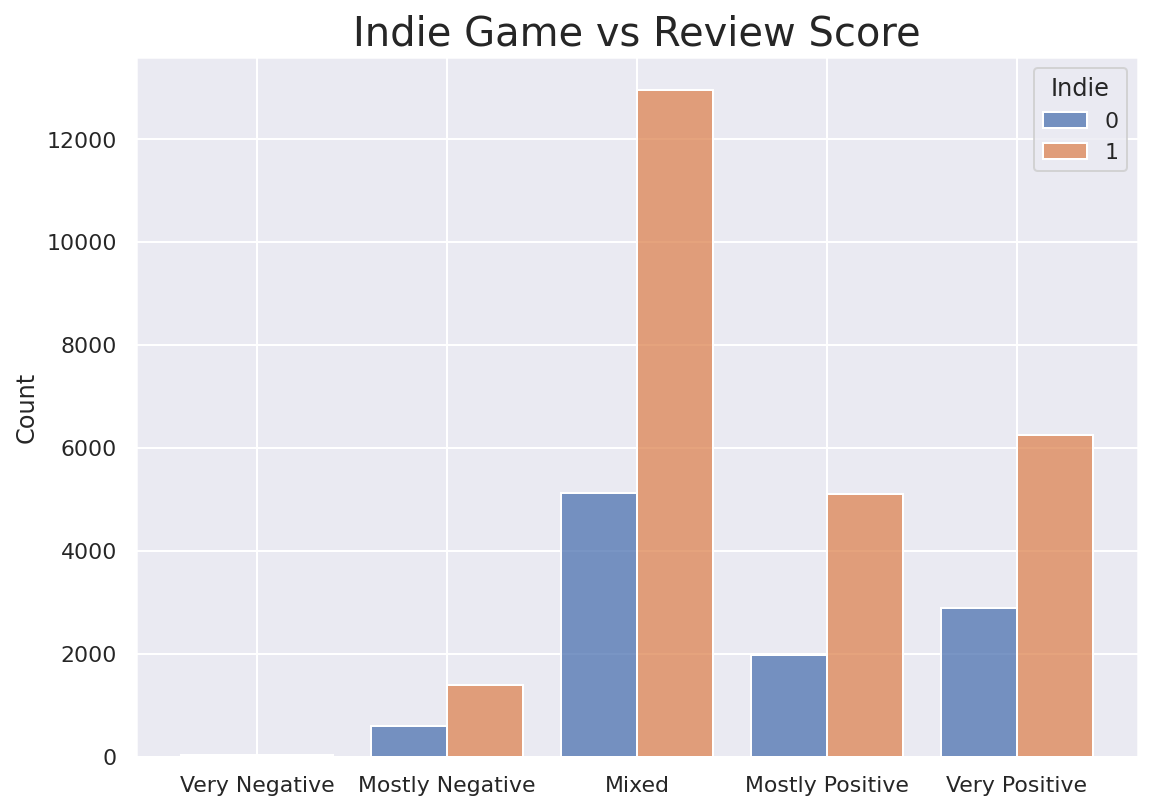

In [ ]:
plt.figure(figsize=(8,6))
fig = sns.histplot(x='steam_userscore_group', data=df, hue = 'Indie', multiple="dodge", shrink=.8)
plt.xlabel('')
fig.set_xticklabels([0, 'Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
plt.title('Indie Game vs Review Score', fontsize=20)
plt.show()

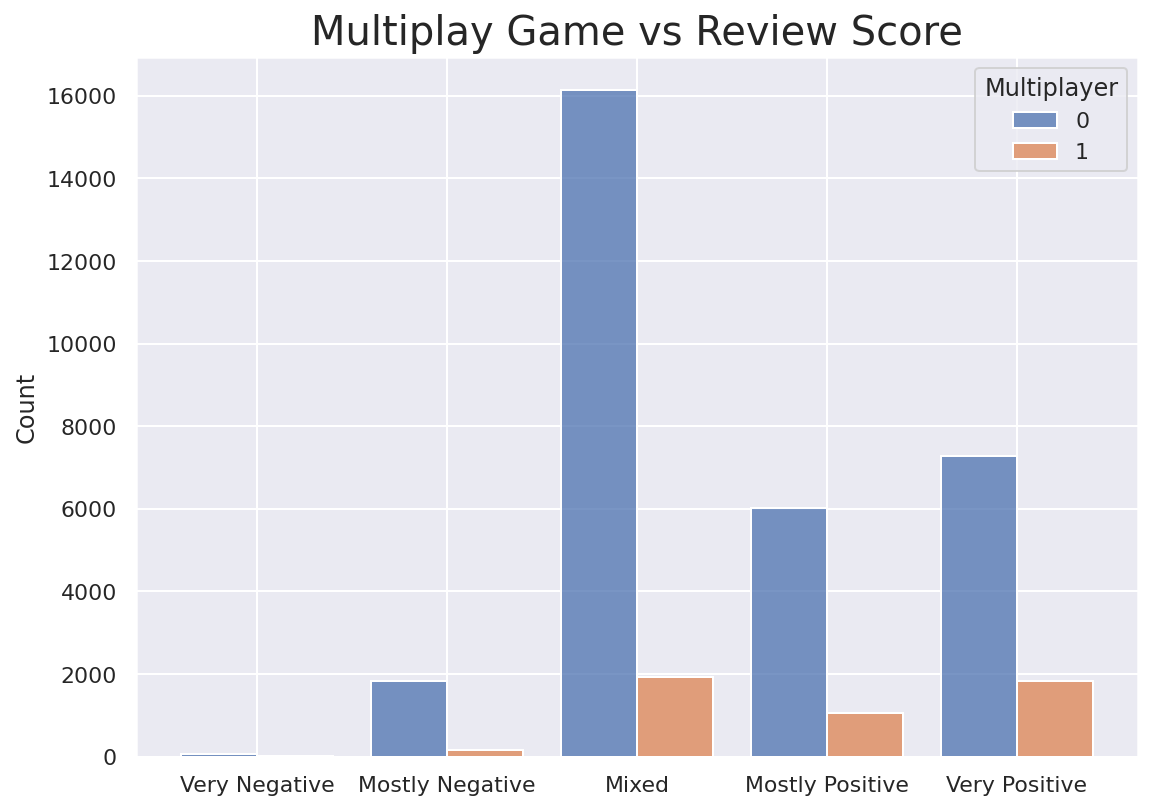

In [ ]:
plt.figure(figsize=(8,6))
fig = sns.histplot(x='steam_userscore_group', data=df, hue = 'Multiplayer', multiple="dodge", shrink=.8)
plt.xlabel('')
fig.set_xticklabels([0, 'Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
plt.title('Multiplay Game vs Review Score', fontsize=20)
plt.show()

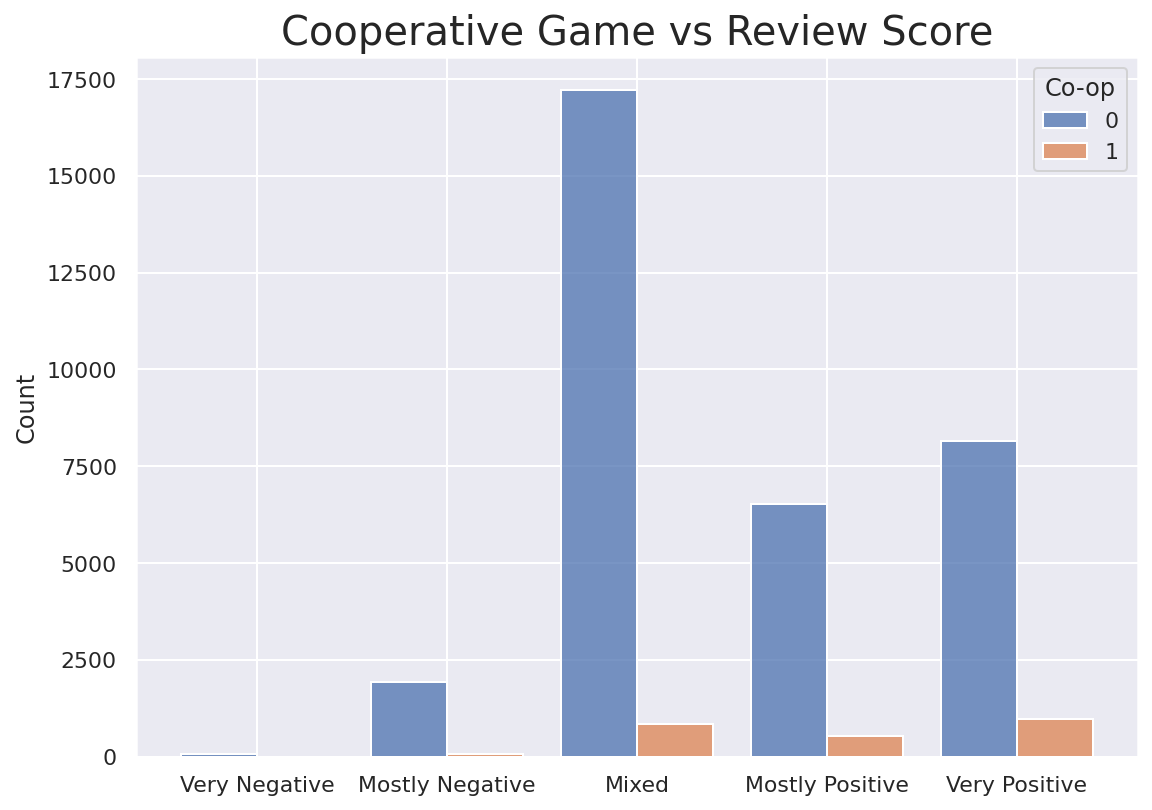

In [ ]:
plt.figure(figsize=(8,6))
fig = sns.histplot(x='steam_userscore_group', data=df, hue = 'Co-op', multiple="dodge", shrink=.8)
plt.xlabel('')
fig.set_xticklabels([0, 'Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
plt.title('Cooperative Game vs Review Score', fontsize=20)
plt.show()

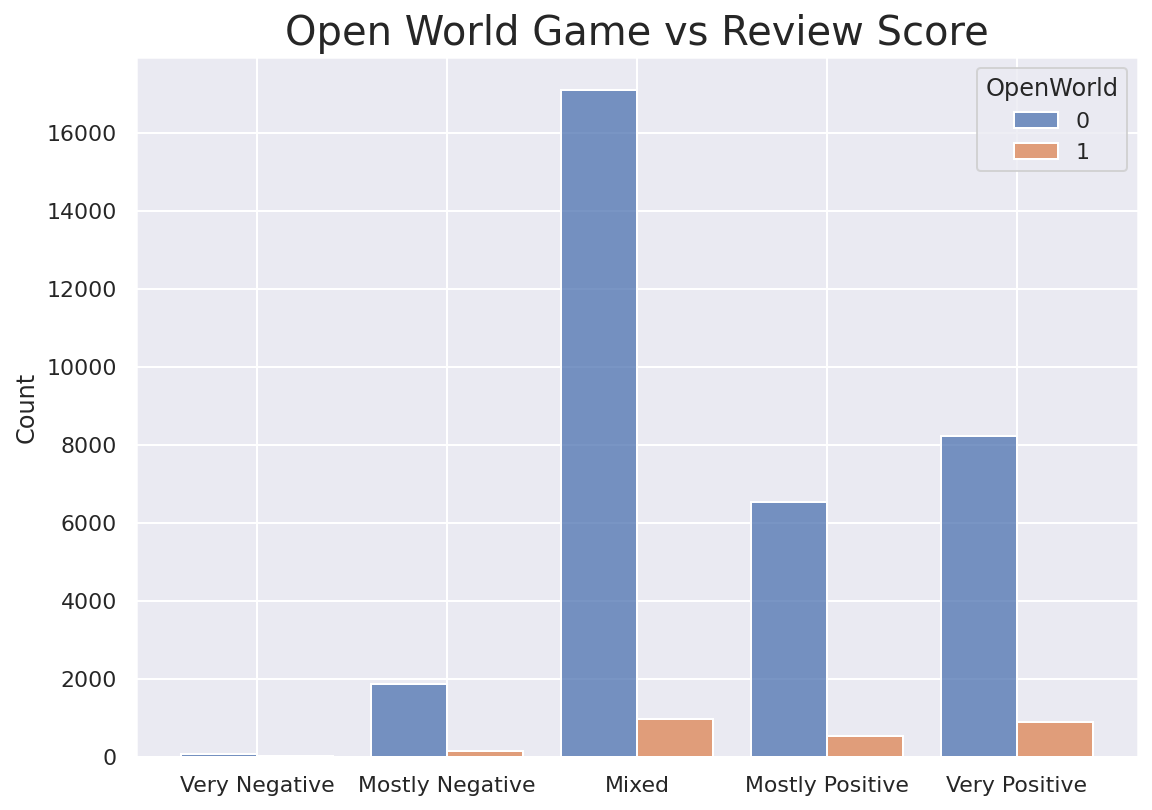

In [ ]:
plt.figure(figsize=(8,6))
fig = sns.histplot(x='steam_userscore_group', data=df, hue = 'OpenWorld', multiple="dodge", shrink=.8)
plt.xlabel('')
fig.set_xticklabels([0, 'Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
plt.title('Open World Game vs Review Score', fontsize=20)
plt.show()

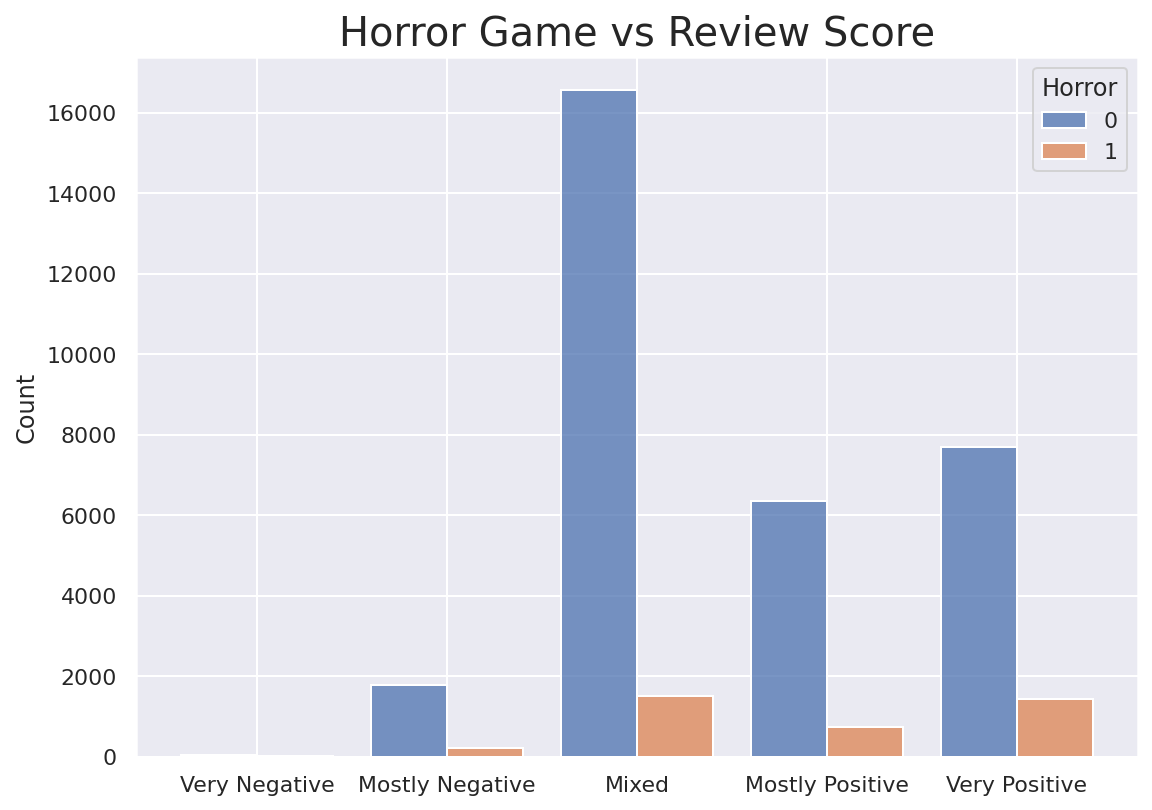

In [ ]:
plt.figure(figsize=(8,6))
fig = sns.histplot(x='steam_userscore_group', data=df, hue = 'Horror', multiple="dodge", shrink=.8)
plt.xlabel('')
fig.set_xticklabels([0, 'Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
plt.title('Horror Game vs Review Score', fontsize=20)
plt.show()

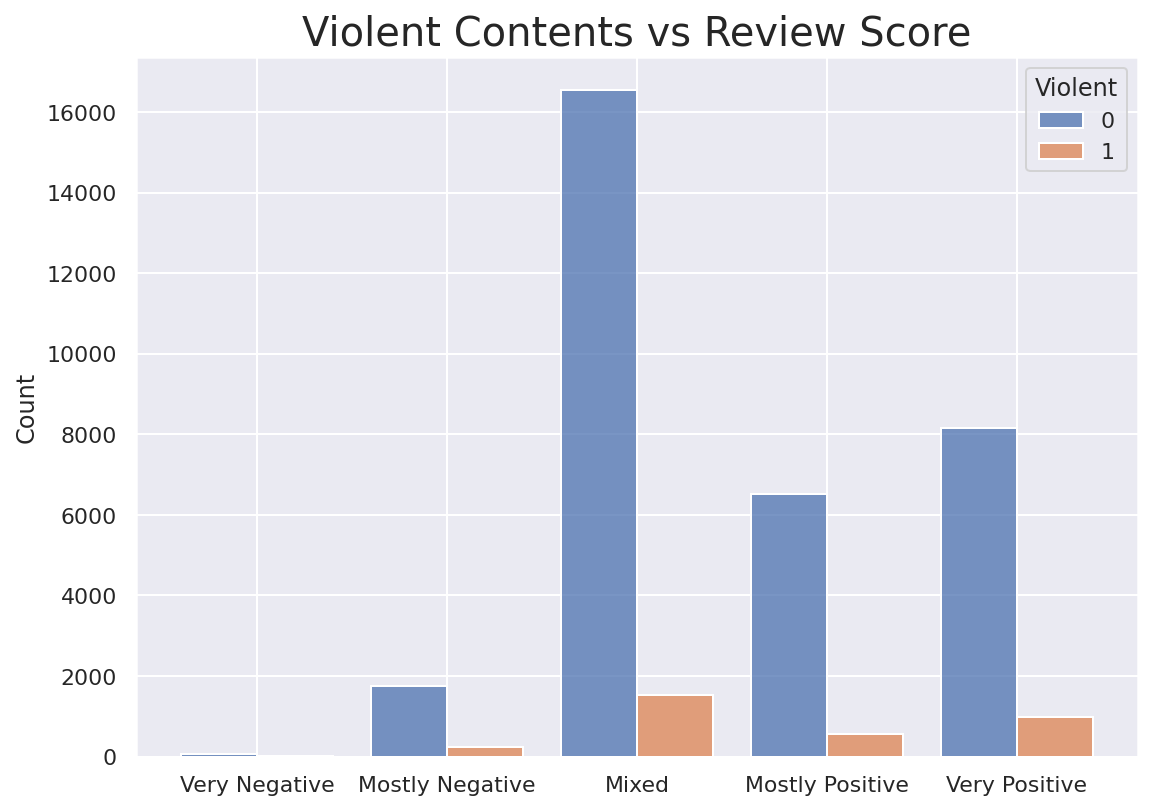

In [ ]:
plt.figure(figsize=(8,6))
fig = sns.histplot(x='steam_userscore_group', data=df, hue = 'Violent', multiple="dodge", shrink=.8)
plt.xlabel('')
fig.set_xticklabels([0, 'Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
plt.title('Violent Contents vs Review Score', fontsize=20)
plt.show()

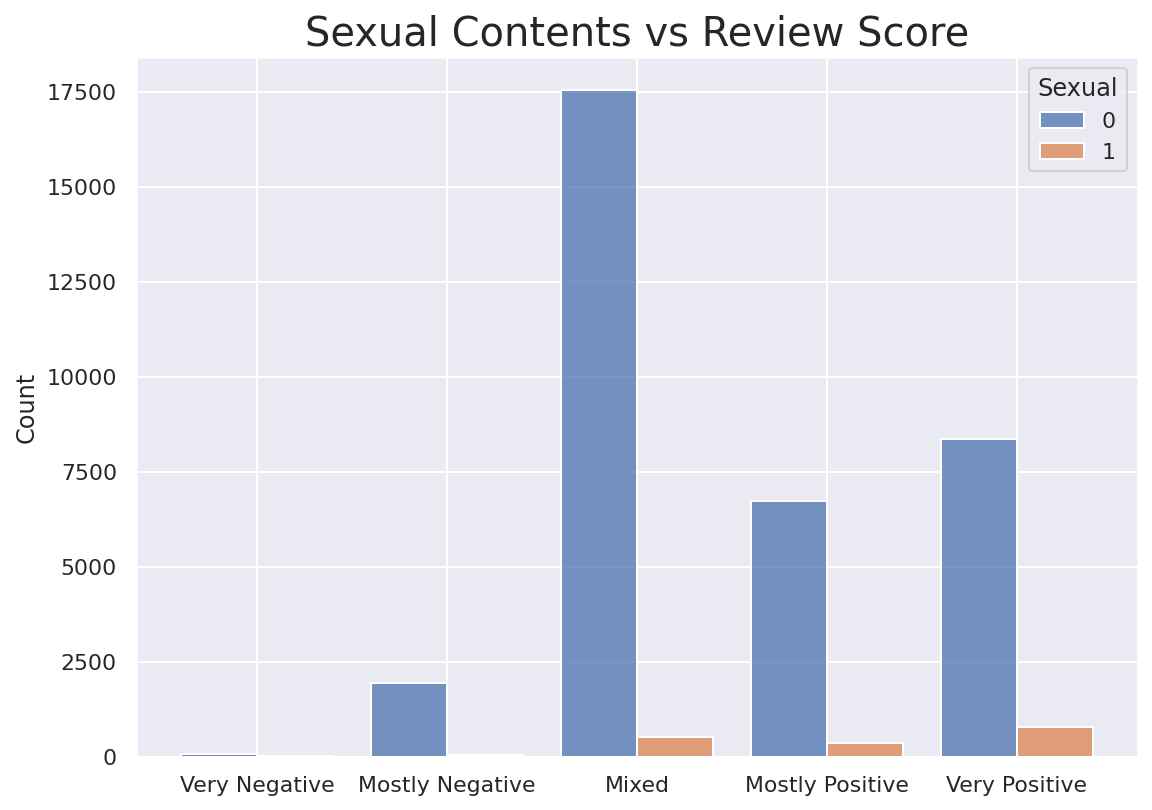

In [ ]:
plt.figure(figsize=(8,6))
fig = sns.histplot(x='steam_userscore_group', data=df, hue = 'Sexual', multiple="dodge", shrink=.8)
plt.xlabel('')
fig.set_xticklabels([0, 'Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
plt.title('Sexual Contents vs Review Score', fontsize=20)
plt.show()

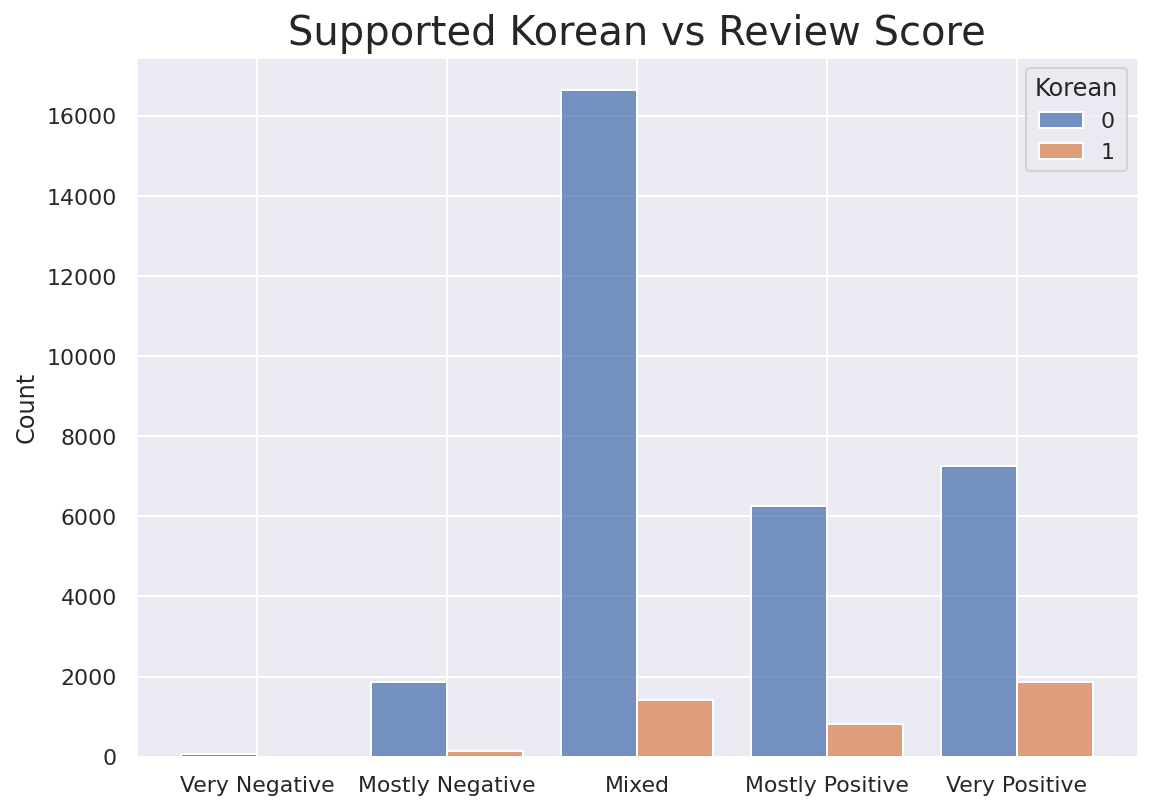

In [ ]:
plt.figure(figsize=(8,6))
fig = sns.histplot(x='steam_userscore_group', data=df, hue = 'Korean', multiple="dodge", shrink=.8)
plt.xlabel('')
fig.set_xticklabels([0, 'Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
plt.title('Supported Korean vs Review Score', fontsize=20)
plt.show()

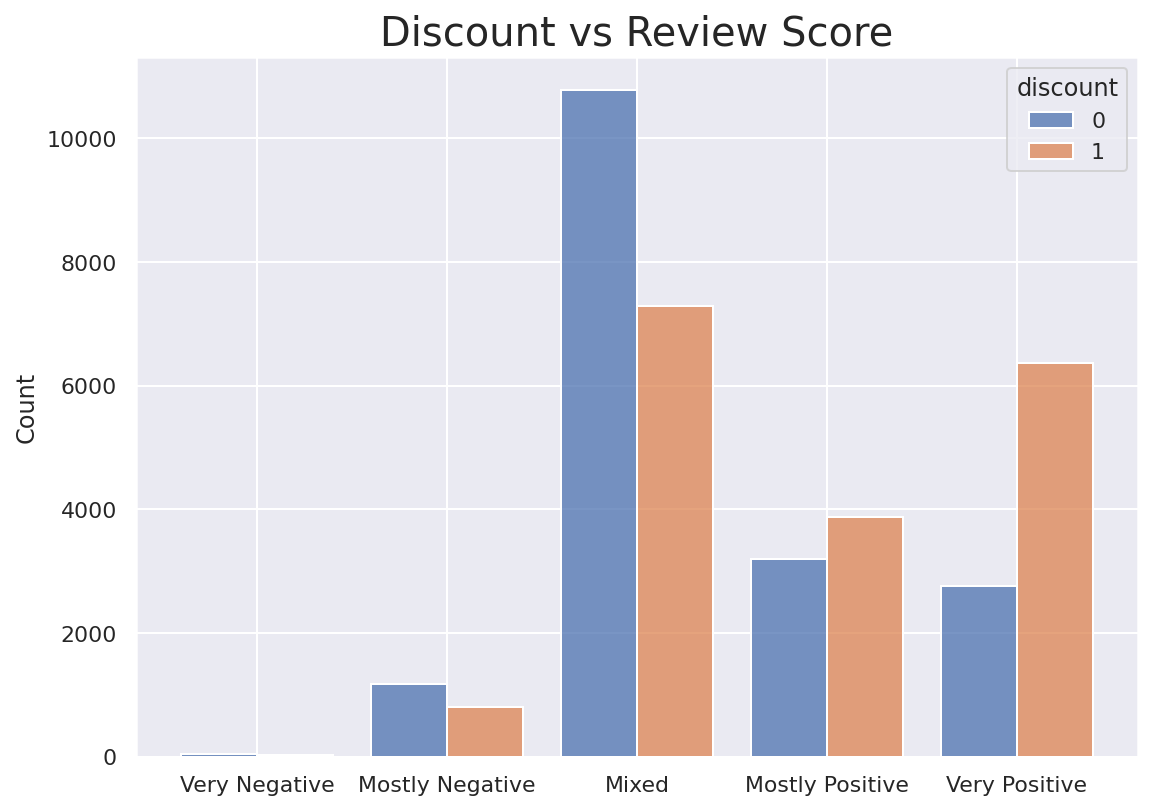

In [ ]:
plt.figure(figsize=(8,6))
fig = sns.histplot(x='steam_userscore_group', data=df, hue = 'discount', multiple="dodge", shrink=.8)
plt.xlabel('')
fig.set_xticklabels([0, 'Very Negative', 'Mostly Negative', 'Mixed', 'Mostly Positive', 'Very Positive'])
plt.title('Discount vs Review Score', fontsize=20)
plt.show()

# Modeling

In [17]:
df.dtypes

appid                            int64
name                            object
developer                       object
publisher                       object
owners                          object
average_playtime_from_2009       int64
initial_price                  float64
current_price                  float64
discount_precent               float64
ccu                              int64
release_year                     int64
Genre                           object
Indie                            int64
Multiplayer                      int64
Co-op                            int64
OpenWorld                        int64
Horror                           int64
Violent                          int64
Sexual                           int64
Num_Language                     int64
Korean                           int64
discount                         int64
price_group                   category
steam_userscore_group         category
dtype: object

In [15]:
df['Genre'] = df['price_group'].astype(int)
df['price_group'] = df['price_group'].astype(int)

feature = ['Genre', 'Indie', 'Multiplayer', 'Co-op', 'OpenWorld', 'Horror', 'Violent', 'Sexual',
           'Korean', 'discount', 'Num_Language', 'price_group']
target = 'steam_userscore_group'
# X = df[feature]
# y = df[[target]]
X = df[feature].values #array
y = df[[target]].values #array

kfold = StratifiedKFold(n_splits= 5, shuffle = True, random_state = 42)
# for train_index, test_index in kfold.split(X, y):
#     X_train, X_test = X.loc[train_index], X.loc[test_index]
#     y_train, y_test = y.loc[train_index], y.loc[test_index]
#     print(X_train.shape, X_test.shape)

## Model Test

- Logistic Regression
- Decision Tree
- Random Forests
- Extra Trees
- Support Vector Machine
- Naive Bayes
- KNN
- Gradient Boostiong
- AdaBoosting
- XGBoost
- LightGBM


In [ ]:
X.dtypes

Genre             object
Indie              int64
Multiplayer        int64
Co-op              int64
OpenWorld          int64
Horror             int64
Violent            int64
Sexual             int64
Korean             int64
discount           int64
Num_Language       int64
price_group     category
dtype: object

### AUC score

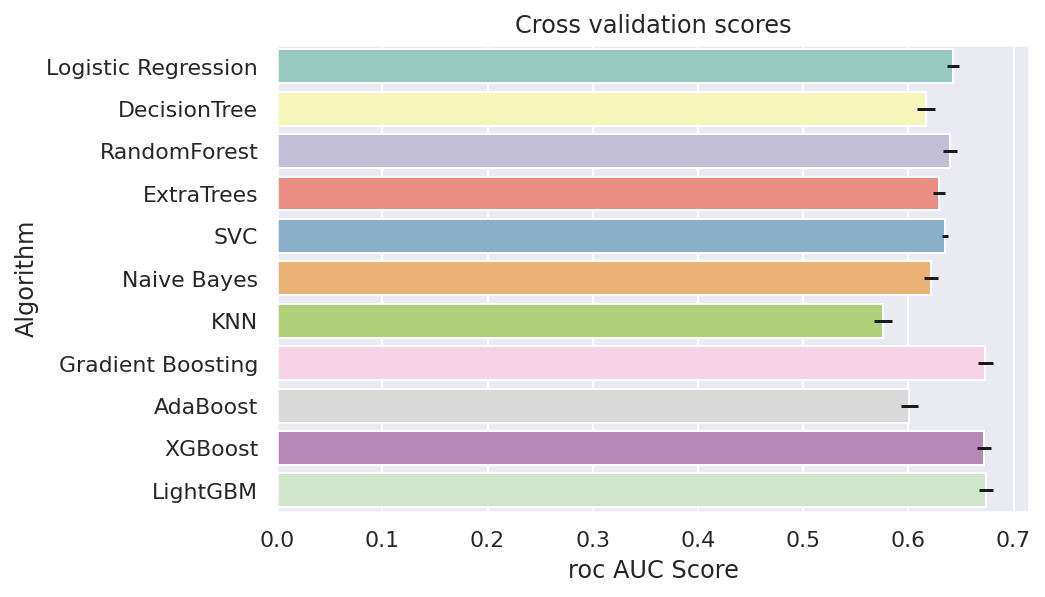

In [ ]:
random_state = 42
models = []
models.append(LogisticRegression())
models.append(DecisionTreeClassifier(random_state = random_state))
models.append(RandomForestClassifier(n_jobs=-1, random_state=random_state))
models.append(ExtraTreesClassifier(n_jobs=-1, random_state=random_state))
models.append(SVC(decision_function_shape='ovr', probability=True, random_state = random_state))
models.append(GaussianNB())
models.append(KNeighborsClassifier(n_jobs=-1))
models.append(GradientBoostingClassifier(random_state=random_state))
models.append(AdaBoostClassifier(random_state=random_state))
models.append(XGBClassifier(random_state=random_state))
models.append(LGBMClassifier(random_state=random_state))

cv_results = []
for model in models:
    cv_results.append(cross_val_score(model, X, y, scoring = 'roc_auc_ovr_weighted',
                                      cv = kfold, n_jobs=-1))
# OvR : One versus the rest


cv_means = []    
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean()) 
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans': cv_means, 'CrossValerrors': cv_std, 
                       'Algorithm':['Logistic Regression', 'DecisionTree', 'RandomForest', 'ExtraTrees', 'SVC', 
                                            'Naive Bayes', 'KNN', 'Gradient Boosting','AdaBoost', 'XGBoost', 'LightGBM']}) 
g = sns.barplot('CrossValMeans', 'Algorithm', data = cv_res, palette='Set3', orient='h',
                **{'xerr':cv_std})   
g.set_xlabel('roc AUC Score')
g = g.set_title('Cross validation scores')

In [ ]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.642603,0.005825,Logistic Regression
1,0.616690,0.008370,DecisionTree
2,0.639781,0.006573,RandomForest
3,0.629178,0.006154,ExtraTrees
4,0.634916,0.002897,SVC
5,0.621529,0.006824,Naive Bayes
6,0.575588,0.008448,KNN
7,0.673114,0.007260,Gradient Boosting
8,0.601064,0.007934,AdaBoost
9,0.671941,0.006705,XGBoost


### F1 score

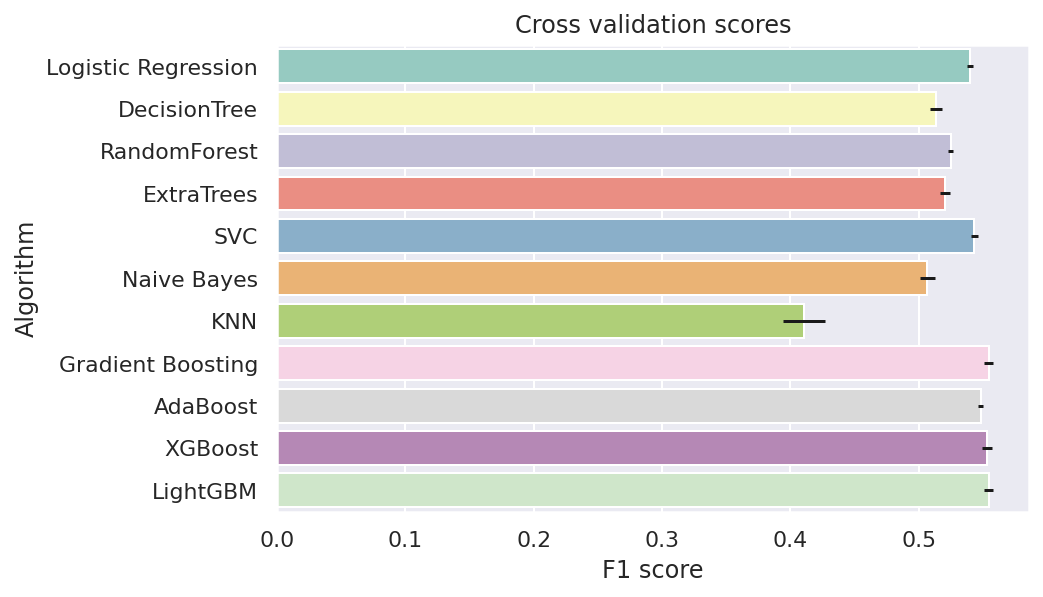

In [ ]:
random_state = 42
models = []
models.append(LogisticRegression())
models.append(DecisionTreeClassifier(random_state = random_state))
models.append(RandomForestClassifier(n_jobs=-1, random_state=random_state))
models.append(ExtraTreesClassifier(n_jobs=-1, random_state=random_state))
models.append(SVC(decision_function_shape='ovr', probability=True, random_state = random_state))
models.append(GaussianNB())
models.append(KNeighborsClassifier(n_jobs=-1))
models.append(GradientBoostingClassifier(random_state=random_state))
models.append(AdaBoostClassifier(random_state=random_state))
models.append(XGBClassifier(random_state=random_state))
models.append(LGBMClassifier(random_state=random_state))

cv_results = []
for model in models:
    cv_results.append(cross_val_score(model, X, y, scoring = 'f1_micro',
                                      cv = kfold, n_jobs=-1))


cv_means = []    
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean()) 
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans': cv_means, 'CrossValerrors': cv_std, 
                       'Algorithm':['Logistic Regression', 'DecisionTree', 'RandomForest', 'ExtraTrees', 'SVC', 
                                            'Naive Bayes', 'KNN', 'Gradient Boosting','AdaBoost', 'XGBoost', 'LightGBM']}) 
g = sns.barplot('CrossValMeans', 'Algorithm', data = cv_res, palette='Set3', orient='h',
                **{'xerr':cv_std})   
g.set_xlabel('F1 score')
g = g.set_title('Cross validation scores')

In [ ]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.539872,0.002323,Logistic Regression
1,0.513575,0.004541,DecisionTree
2,0.524865,0.001947,RandomForest
3,0.520487,0.003992,ExtraTrees
4,0.543507,0.002994,SVC
5,0.506856,0.005543,Naive Bayes
6,0.410701,0.016261,KNN
7,0.554466,0.003506,Gradient Boosting
8,0.548326,0.002140,AdaBoost
9,0.553558,0.003852,XGBoost


F1 score
- https://sw-data.tistory.com/23
- https://junklee.tistory.com/116

## Voting Classifier (Gradient Boosting, XGBoost, LightGBM)

### F1 score

In [ ]:
random_state = 42
kfold = StratifiedKFold(n_splits= 5, shuffle = True, random_state = 42) # 모델 훈련시간을 고려해, n_split을 5회로 감소
gb = GradientBoostingClassifier(random_state=random_state)
xgb = XGBClassifier(objective = 'multi:softmax', random_state=random_state, n_jobs=-1)
lgbm = LGBMClassifier(objective = 'multiclass', class_weight  = 'balanced', random_state=random_state,
                      n_jobs = -1)

voting_model = VotingClassifier(estimators=[('gb',gb), ('xgb', xgb), ('lgbm',lgbm)], voting='soft', n_jobs=-1)

params = [{'gb__n_estimators':[100],
           'gb__max_depth':[5],
           'xgb__n_estimators': [100],
           'xgb__max_depth':[2],
           'lgbm__boosting_type' : ['dart'],  
           'lgbm__n_estimators':[100],
           'lgbm__max_depth':[12]
           }]

grid = GridSearchCV(voting_model,params, cv=kfold.split(X,y),scoring='f1_micro', n_jobs=-1, verbose=1)

grid.fit(X,y)
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'gb__max_depth': 5, 'gb__n_estimators': 100, 'lgbm__boosting_type': 'dart', 'lgbm__max_depth': 12, 'lgbm__n_estimators': 100, 'xgb__max_depth': 2, 'xgb__n_estimators': 100}
0.5550721712123666


성능 검증

In [ ]:
random_state = 42
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

gb = GradientBoostingClassifier(n_estimators=100, max_depth= 5, random_state=random_state)
xgb = XGBClassifier(n_estimators=100, max_depth=2, objective = 'multi:softmax', random_state=random_state, n_jobs=-1)
lgbm = LGBMClassifier(boosting_type='dart', max_depth=12, n_estimators=100, objective = 'multiclass', class_weight  = 'balanced', random_state=random_state,
                      n_jobs = -1)

voting_model = VotingClassifier(estimators=[('gb',gb), ('lgbm',lgbm)], voting='soft', n_jobs=-1)
voting_model.fit(X_train, y_train)

pred = voting_model.predict(X_val)
pred_prob = voting_model.predict_proba(X_val)

print(f1_score(y_val, pred, average='micro'))
print(accuracy_score(y_val, pred))

0.5489674162459844
0.5489674162459844


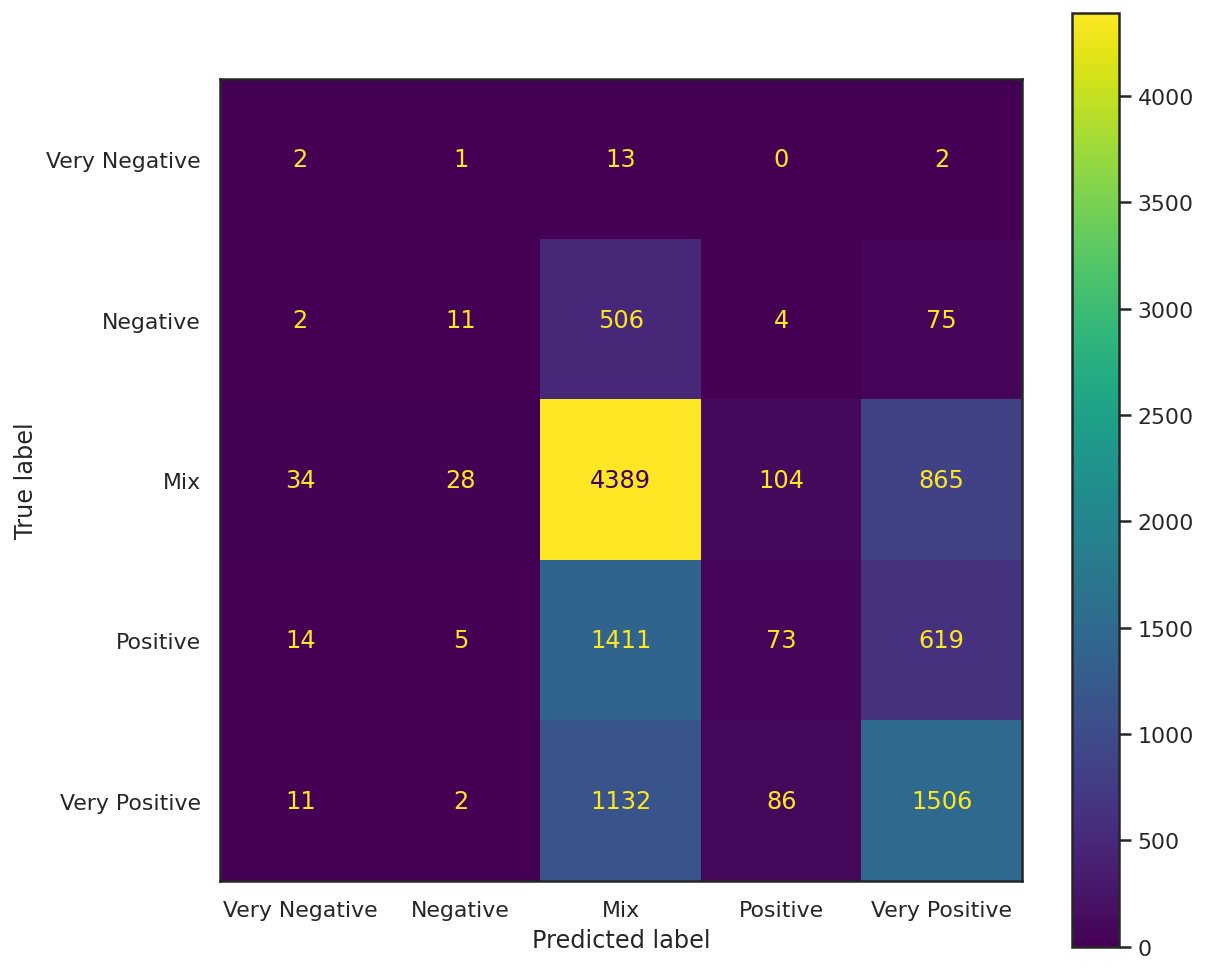

In [ ]:
# confusion matrix
sns.set_style('white')
fig, ax = plt.subplots(figsize = (8,8))
pcm = plot_confusion_matrix(voting_model, X_val, y_val,
                        values_format = 'd',
                        display_labels = ['Very Negative', 'Negative', 'Mix', 'Positive', 'Very Positive'],
                        ax = ax);

In [ ]:
roc_auc_score(y_val, pred_prob, average = 'weighted', multi_class = 'ovr')

0.6726886431594639

### AUC score

- 500MB 제한 확인할 것 (Heroku)

Hyperparameter tuning

In [ ]:
random_state = 42
kfold = StratifiedKFold(n_splits= 5, shuffle = True, random_state = 42) # 모델 훈련시간을 고려해, n_split을 5회로 감소
gb = GradientBoostingClassifier(random_state=random_state)
xgb = XGBClassifier(objective = 'multi:softmax', random_state=random_state, n_jobs=-1)
lgbm = LGBMClassifier(objective = 'multiclass', class_weight  = 'balanced', random_state=random_state,
                      n_jobs = -1)

voting_model = VotingClassifier(estimators=[('gb',gb), ('xgb',xgb), ('lgbm',lgbm)], voting='soft', n_jobs=-1)

params = [{'gb__n_estimators':[200], 'gb__max_depth':[3],
           'xgb__n_estimators' : [100], 'xgb__max_depth' : [6],
           'lgbm__boosting_type' : ['dart'],  'lgbm__n_estimators':[300],
           'lgbm__max_depth':[10,11]
}]

grid = GridSearchCV(voting_model,params, cv=kfold.split(X,y),scoring='roc_auc_ovr_weighted', n_jobs=-1, verbose=2)

grid.fit(X,y)
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'gb__max_depth': 3, 'gb__n_estimators': 200, 'lgbm__boosting_type': 'dart', 'lgbm__max_depth': 11, 'lgbm__n_estimators': 300, 'xgb__max_depth': 6, 'xgb__n_estimators': 100}
0.6729202606310818


성능 검증

In [16]:
random_state = 42
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

gb = GradientBoostingClassifier(n_estimators=200, max_depth= 3, random_state=random_state)
xgb = XGBClassifier(n_estimators=100, max_depth= 6, objective = 'multi:softmax', random_state=random_state, n_jobs=-1)
lgbm = LGBMClassifier(boosting_type='dart', max_depth=11, n_estimators=300, objective = 'multiclass', class_weight  = 'balanced', random_state=random_state,n_jobs = -1)

voting_model = VotingClassifier(estimators=[('gb',gb), ('xgb',xgb), ('lgbm',lgbm)], voting='soft', n_jobs=-1)
voting_model.fit(X_train, y_train)

pred = voting_model.predict(X_val)
pred_prob = voting_model.predict_proba(X_val)

print(f1_score(y_val, pred, average='micro'))
print(accuracy_score(y_val, pred))
print(roc_auc_score(y_val, pred_prob, average = 'weighted', multi_class = 'ovr'))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.5516291877007802
0.5516291877007802
0.6672689387151101


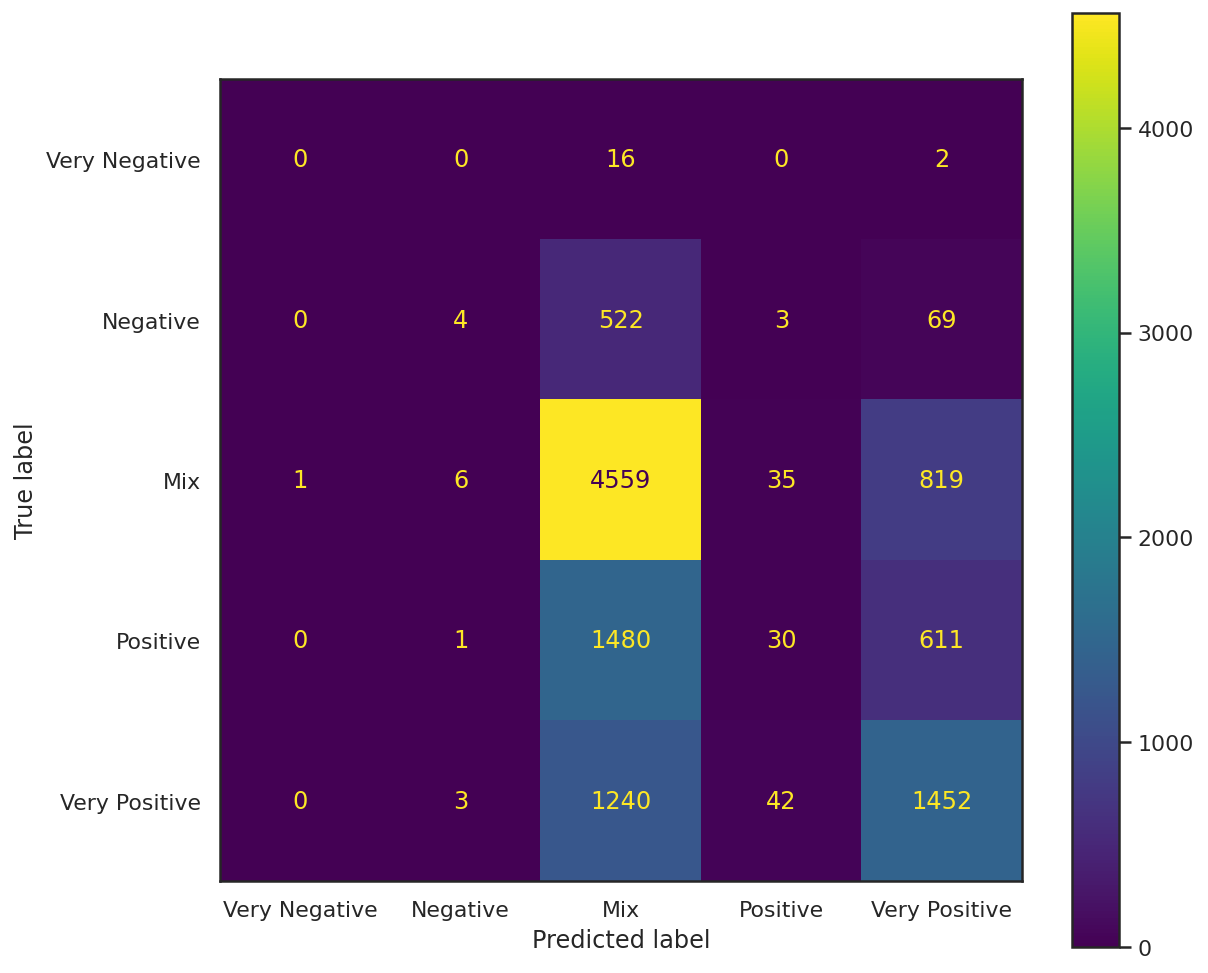

In [ ]:
# confusion matrix
sns.set_style('white')
fig, ax = plt.subplots(figsize = (8,8))
pcm = plot_confusion_matrix(voting_model, X_val, y_val,
                        values_format = 'd',
                        display_labels = ['Very Negative', 'Negative', 'Mix', 'Positive', 'Very Positive'],
                        ax = ax);

In [ ]:
print(classification_report(y_val,pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.29      0.01      0.01       598
           2       0.58      0.84      0.69      5420
           3       0.27      0.01      0.03      2122
           4       0.49      0.53      0.51      2737

    accuracy                           0.55     10895
   macro avg       0.33      0.28      0.25     10895
weighted avg       0.48      0.55      0.48     10895



In [17]:
import pickle
with open('voing_model.pickle','wb') as fw:
    pickle.dump(voting_model, fw)

In [58]:
voting_model

VotingClassifier(estimators=[('gb',
                              GradientBoostingClassifier(n_estimators=200,
                                                         random_state=42)),
                             ('xgb',
                              XGBClassifier(max_depth=6, n_jobs=-1,
                                            objective='multi:softmax',
                                            random_state=42)),
                             ('lgbm',
                              LGBMClassifier(boosting_type='dart',
                                             class_weight='balanced',
                                             max_depth=11, n_estimators=300,
                                             objective='multiclass',
                                             random_state=42))],
                 n_jobs=-1, voting='soft')

In [26]:
import joblib
joblib.dump(voting_model, 'voing_model.pkl')

['voing_model.pkl']

## Voting Classifier  (Gradient Boosting, LightGBM)

In [ ]:
random_state = 42
kfold = StratifiedKFold(n_splits= 5, shuffle = True, random_state = 42) # 모델 훈련시간을 고려해, n_split을 5회로 감소
gb = GradientBoostingClassifier(random_state=random_state)
lgbm = LGBMClassifier(objective = 'multiclass', class_weight  = 'balanced', random_state=random_state,
                      n_jobs = -1)

voting_model = VotingClassifier(estimators=[('gb',gb), ('lgbm',lgbm)], voting='soft', n_jobs=-1)

params = [{'gb__n_estimators':[200], 'gb__max_depth':[3],
           'lgbm__boosting_type' : ['dart'],  'lgbm__n_estimators':[300],
           'lgbm__max_depth':[8,10]
}]

grid = GridSearchCV(voting_model,params, cv=kfold.split(X,y),scoring='roc_auc_ovr_weighted', n_jobs=-1, verbose=2)

grid.fit(X,y)
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
random_state = 42
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

gb = GradientBoostingClassifier(n_estimators=200, 
                                max_depth= 3, random_state=random_state)
lgbm = LGBMClassifier(boosting_type='dart', max_depth=10, n_estimators=300, objective = 'multiclass', class_weight  = 'balanced', random_state=random_state,
                      n_jobs = -1)

voting_model = VotingClassifier(estimators=[('gb',gb), ('lgbm',lgbm)], voting='soft', n_jobs=-1)
voting_model.fit(X_train, y_train)

pred = voting_model.predict(X_val)
pred_prob = voting_model.predict_proba(X_val)

print(f1_score(y_val, pred, average='micro'))
print(accuracy_score(y_val, pred))
print(roc_auc_score(y_val, pred_prob, average = 'weighted', multi_class = 'ovr'))

0.5446535107847637
0.5446535107847637
0.6731076840897044


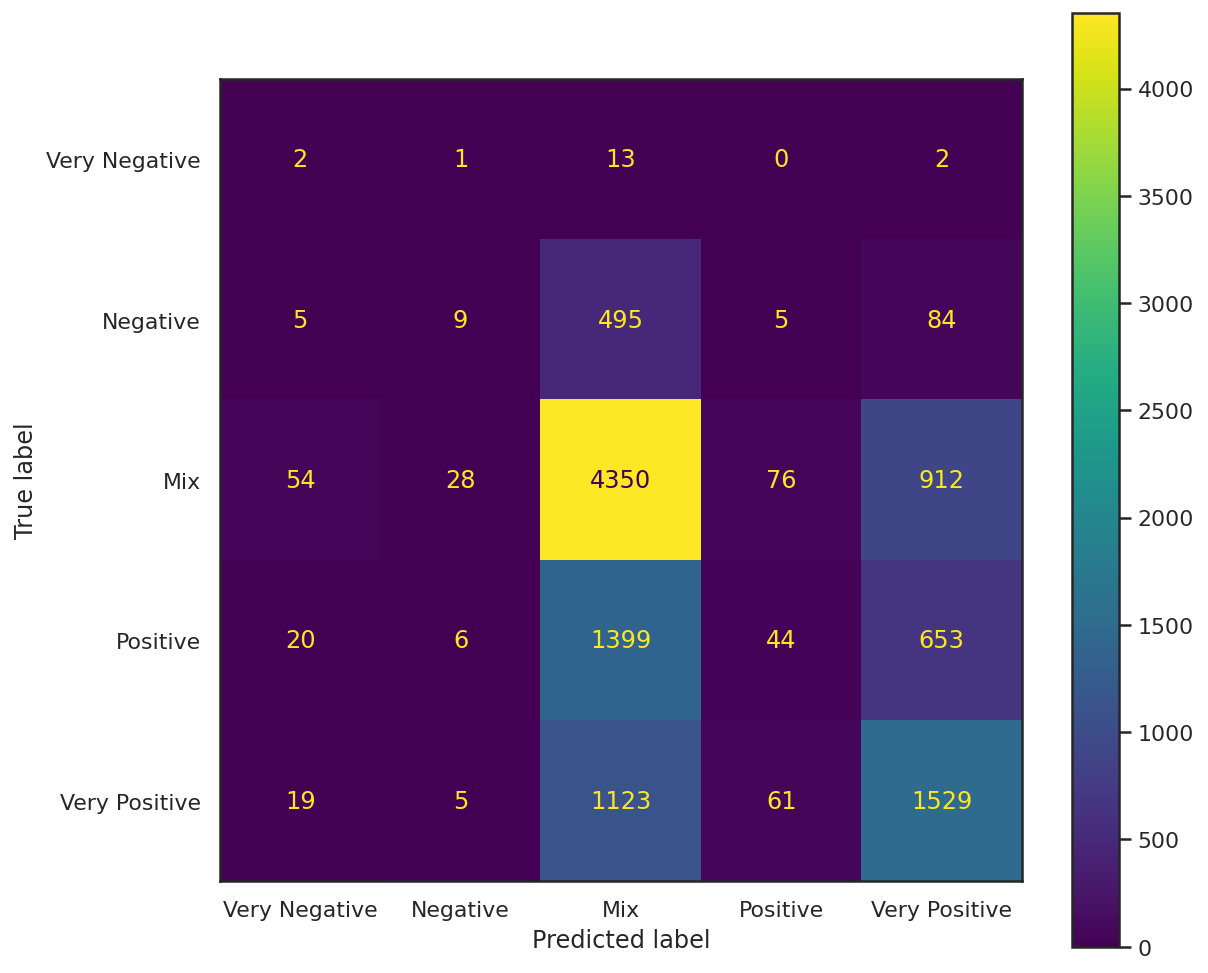

In [ ]:
# confusion matrix
sns.set_style('white')
fig, ax = plt.subplots(figsize = (8,8))
pcm = plot_confusion_matrix(voting_model, X_val, y_val,
                        values_format = 'd',
                        display_labels = ['Very Negative', 'Negative', 'Mix', 'Positive', 'Very Positive'],
                        ax = ax);

In [ ]:
print(classification_report(y_val,pred))

              precision    recall  f1-score   support

           0       0.02      0.11      0.03        18
           1       0.18      0.02      0.03       598
           2       0.59      0.80      0.68      5420
           3       0.24      0.02      0.04      2122
           4       0.48      0.56      0.52      2737

    accuracy                           0.54     10895
   macro avg       0.30      0.30      0.26     10895
weighted avg       0.47      0.54      0.48     10895



In [ ]:
import joblib
joblib.dump(voting_model, 'voing_model.pkl')

['voing_model.pkl']

## LightGBM

- https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/
- https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

### Hyperparameter tuning

In [ ]:
random_state = 42
kfold = StratifiedKFold(n_splits= 5, shuffle = True, random_state = 42) # 모델 훈련시간을 고려해, n_split을 5회로 감소
lgbm = LGBMClassifier(objective = 'multiclass', class_weight  = 'balanced', random_state=random_state,
                      n_jobs = -1)

params = {'n_estimators':[100,200,300],
        'learning_rate':[0.15], 
        'boosting_type':['dart'],
        'num_leaves' : [24],
        'max_depth' : [13],
        'min_child_samples' : [25],
        'min_child_weight' : [1e-5],
        'colsample_bytree' : [0.9],
        'subsample' : [0.92]
}

lgbm_grid = GridSearchCV(lgbm,params, cv=kfold.split(X,y), 
                        scoring='roc_auc_ovr_weighted', 
                        n_jobs=-1, 
                        verbose=True)

# lgbm_rdsc = RandomizedSearchCV(lgbm, params,
#                                n_iter=30,
#                                scoring='roc_auc_ovr_weighted',
#                                n_jobs= -1,
#                                cv=kfold.split(X,y), 
#                                verbose=True, 
#                                random_state=random_state)


lgbm_grid.fit(X,y)
print(lgbm_grid.best_params_)
print(lgbm_grid.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 61
[LightGBM] [Info] Number of data points in the train set: 36316, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 4 dense feature groups (0.14 MB) transferred to GPU in 0.000752 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
{'boosting_type': 'dart', 'colsample_bytree': 0.9, 'learning_rate': 0.15, 'max_depth': 13, 'min_child_samples': 25, 'min_child_weight': 1e-05, 'n_estimators': 100

- Best Parameter
```
'n_estimators' : 100,
'learning_rate':0.15,
'boosting_type':'dart',
'num_leaves' : 24
'max_depth' : 13
'min_child_samples' : 25
'min_child_weight' : 1e-5
'colsample_bytree' : 0.9
'subsample' : 0.92
```               

In [ ]:
random_state = 42
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

lgbm = LGBMClassifier(objective = 'multiclass', class_weight  = 'balanced', random_state=random_state,
                      n_jobs = -1,
                      n_estimators = 100,
                      learning_rate = 0.15,
                      boosting_type= 'dart',
                      num_leaves = 24,
                      max_depth = 13,
                      min_child_samples = 25,
                      min_child_weight = 1e-5,
                      colsample_bytree = 0.9,
                      subsample = 0.92)

eval_set = [(X_val, y_val)]

lgbm.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    #eval_metric = 'auc_mu' Error로 인해 실행 불가능..
)

[1]	valid_0's multi_logloss: 1.58944
[2]	valid_0's multi_logloss: 1.56836
[3]	valid_0's multi_logloss: 1.55182
[4]	valid_0's multi_logloss: 1.53761
[5]	valid_0's multi_logloss: 1.52481
[6]	valid_0's multi_logloss: 1.51469
[7]	valid_0's multi_logloss: 1.51578
[8]	valid_0's multi_logloss: 1.50656
[9]	valid_0's multi_logloss: 1.49859
[10]	valid_0's multi_logloss: 1.50061
[11]	valid_0's multi_logloss: 1.49374
[12]	valid_0's multi_logloss: 1.49563
[13]	valid_0's multi_logloss: 1.48824
[14]	valid_0's multi_logloss: 1.48187
[15]	valid_0's multi_logloss: 1.47606
[16]	valid_0's multi_logloss: 1.47063
[17]	valid_0's multi_logloss: 1.47217
[18]	valid_0's multi_logloss: 1.4676
[19]	valid_0's multi_logloss: 1.46775
[20]	valid_0's multi_logloss: 1.46795
[21]	valid_0's multi_logloss: 1.47015
[22]	valid_0's multi_logloss: 1.47287
[23]	valid_0's multi_logloss: 1.46814
[24]	valid_0's multi_logloss: 1.47028
[25]	valid_0's multi_logloss: 1.46944
[26]	valid_0's multi_logloss: 1.46486
[27]	valid_0's multi_l

LGBMClassifier(boosting_type='dart', class_weight='balanced',
               colsample_bytree=0.9, learning_rate=0.15, max_depth=13,
               min_child_samples=25, min_child_weight=1e-05, num_leaves=24,
               objective='multiclass', random_state=42, subsample=0.92)

In [ ]:
pred = lgbm.predict(X_val)
pred_prob = lgbm.predict_proba(X_val)

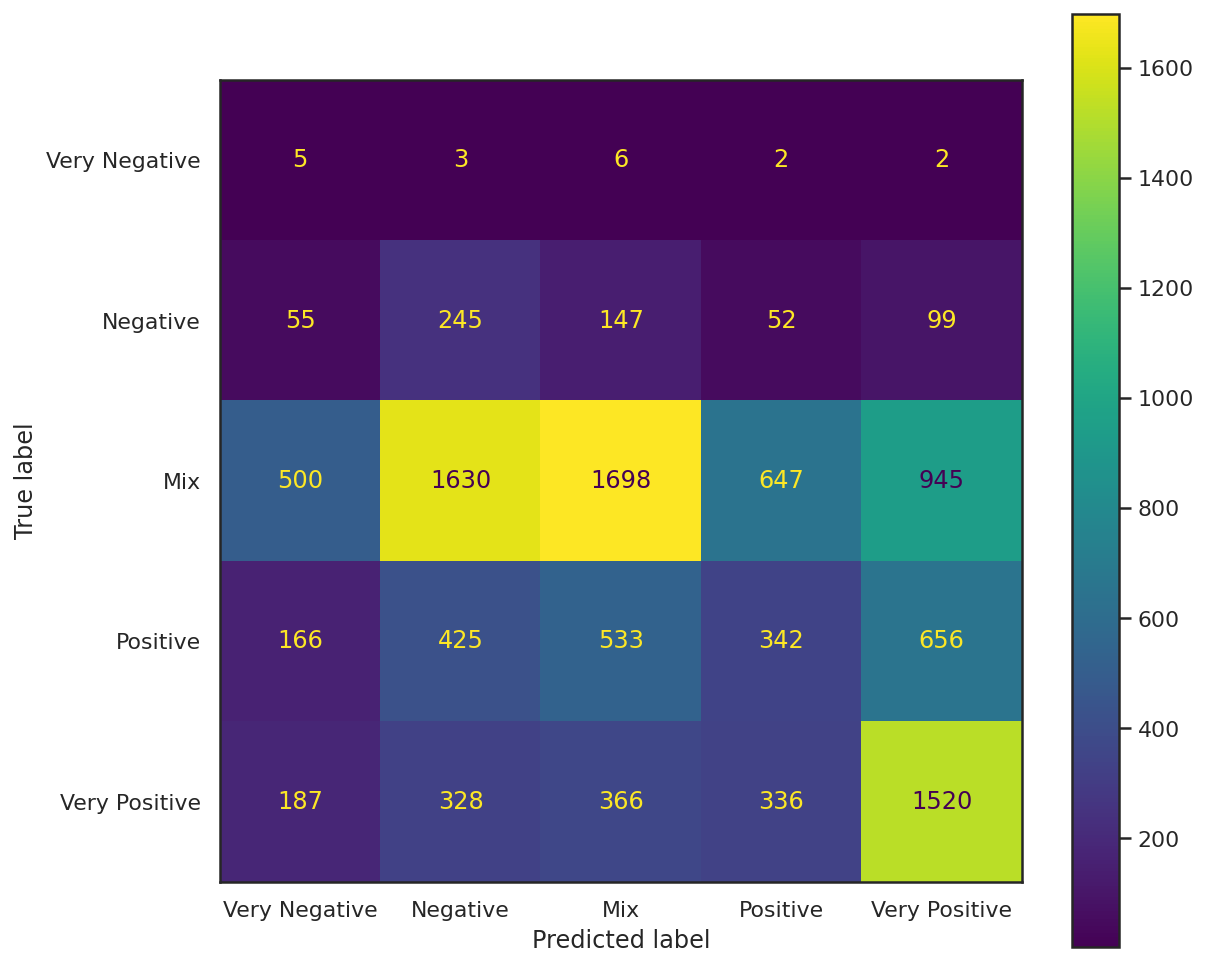

In [ ]:
# confusion matrix
sns.set_style('white')
fig, ax = plt.subplots(figsize = (8,8))
pcm = plot_confusion_matrix(lgbm, X_val, y_val,
                        values_format = 'd',
                        display_labels = ['Very Negative', 'Negative', 'Mix', 'Positive', 'Very Positive'],
                        ax = ax);

In [ ]:
print(classification_report(y_val,pred))

              precision    recall  f1-score   support

           0       0.01      0.28      0.01        18
           1       0.09      0.41      0.15       598
           2       0.62      0.31      0.42      5420
           3       0.25      0.16      0.20      2122
           4       0.47      0.56      0.51      2737

    accuracy                           0.35     10895
   macro avg       0.29      0.34      0.26     10895
weighted avg       0.48      0.35      0.38     10895



In [ ]:
roc_auc_score(y_val, pred_prob, average = 'weighted', multi_class = 'ovr')

0.6571649415794133

In [ ]:
joblib.dump(lgbm, 'lgbm_model.pkl')

['lgbm_model.pkl']

## 특성 중요도

In [ ]:
#  Permutation Importance
random_state = 42
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

perm = PermutationImportance(voting_model, random_state = random_state).fit(X_val, y_val)
eli5.show_weights(perm, top = 15, feature_names = feature)


# n = 15
# plt.figure(figsize=(10,n/2))
# plt.title(f'Top {n} features')
# importances.sort_values()[-n:].plot.barh();

Weight,Feature
0.0317 ± 0.0048,price_group
0.0273 ± 0.0024,discount
0.0223 ± 0.0039,Num_Language
0.0072 ± 0.0026,Genre
0.0053 ± 0.0005,Horror
0.0043 ± 0.0013,Multiplayer
0.0021 ± 0.0020,Indie
0.0021 ± 0.0013,Sexual
0.0017 ± 0.0009,OpenWorld
0.0008 ± 0.0013,Korean


In [18]:
import sklearn
import xgboost as xgb
print(sklearn.__version__)
print(xgb.__version__)
print(lgb.__version__)

1.0.2
0.90
3.3.2.99


In [43]:
pip freeze > requirments.txt

In [42]:
import sys
sys.version

'3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]'

In [54]:
X_val

,Genre,Indie,Multiplayer,Co-op,OpenWorld,Horror,Violent,Sexual,Korean,discount,Num_Language,price_group
19479,3,1,1,0,0,0,1,0,0,1,9,3
14973,2,1,0,0,0,0,0,0,0,1,6,2
38,3,0,0,0,0,0,0,0,0,1,1,3
2391,4,1,0,0,0,1,0,0,0,1,3,4
32869,1,1,0,0,0,0,0,0,1,0,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17363,1,0,0,0,0,0,0,0,0,0,1,1
12696,2,1,0,0,0,0,0,0,0,0,2,2
19511,0,1,0,0,0,0,0,0,0,0,1,0
29570,1,1,0,0,0,0,0,0,0,1,1,1


In [56]:
# 모델 Test
import pickle
filename = '/content/voing_model.pickle'
#filename = '/content/voing_model.pkl'
# model = joblib.load(filename) 
with open(filename, 'rb') as f: 
    model = pickle.load(f)
model.get_params

# feature = ['Genre', 'Indie', 'Multiplayer', 'Co-op', 'OpenWorld', 'Horror', 'Violent', 'Sexual',
#            'Korean', 'discount', 'Num_Language', 'price_group']
#model.set_params


# value = np.array([[1,1,0,0, 0, 0, 1, 0,1, 1, 12 ,2]])
# value
# model.predict(value)
# pred = model.predict([[1,1,0,0, 0, 0, 1, 0,
#                            1, 1, 12 ,2]])
# prob = model.predict_proba([[1,1,0,0, 0, 0, 1, 0,
#                            1, 1, 12 ,2]])
# print(pred)
# print(prob.max())

<bound method _BaseHeterogeneousEnsemble.get_params of VotingClassifier(estimators=[('gb',
                              GradientBoostingClassifier(n_estimators=200,
                                                         random_state=42)),
                             ('xgb',
                              XGBClassifier(max_depth=6, missing=nan, n_jobs=-1,
                                            objective='multi:softmax',
                                            random_state=42)),
                             ('lgbm',
                              LGBMClassifier(boosting_type='dart',
                                             class_weight='balanced',
                                             max_depth=11, n_estimators=300,
                                             objective='multiclass',
                                             random_state=42))],
                 n_jobs=-1, voting='soft')>